In [1]:
from pathlib import Path
from src.utils.model_utils import seed_all
from src.utils.model_utils import get_device
from src.utils.data_class import ModelConfig, TrainConfig, DataConfig, LatentForecasterConfig, OptimConfig
from src.model.operations.pipeline import tabular_latent_pipeline
from src.utils.plots import plot_forecast_simple
from src.utils.hpo import random_search_tabular_latent

In [2]:
def run(s, data_cfg: DataConfig, model_cfg: ModelConfig, train_cfg: TrainConfig):
    seed_all(s)
    device = get_device()
    res = tabular_latent_pipeline(data_cfg, model_cfg, train_cfg, device, './../output')
    series = res["X_all"][:, 0]
    y_pred = res["y_pred"]

    plot_forecast_simple(series, y_pred, data_cfg.split_ratio[0])   

In [3]:
DATA = Path("./../data/load")

# Example: pick first file
files = sorted([p for p in DATA.glob("*.csv")])
if not files:
    raise SystemExit(f"No CSVs found in {DATA}")
csv_path = str(files[0])

seed = 42
seed_all(seed)

HORIZON = 150
SPLIT_RATIO = (0.6, 0.2, 0.2)

In [4]:
# HPO search space for your TabularAutoencoder + latent 1-step forecaster setup.
# All values are discrete; random_search_tabular_latent samples uniformly.

space = {
    # -------------------------
    # Data / splitting
    # -------------------------
    "data_cfg.split_ratio": [
        #(0.6, 0.2, 0.2),
        (0.7, 0.1, 0.2),
        #(0.7, 0.15, 0.15),
        #(0.8, 0.1, 0.1),
    ],
    "data_cfg.horizon": [100],

    # Feature engineering
    "data_cfg.lags": [
        (1, 2, 7, 14, 30),
        (1, 7, 14, 28),
        (1, 2, 3, 7, 14),
        (1, 24, 48, 72),          # if your data is hourly
        (1, 24, 168),             # daily + weekly cycle style (hourly data)
    ],
    "data_cfg.rolling_windows": [
        (3, 7),
        (3, 7, 14),
        (7, 14),
        (3, 7, 14, 30),
    ],

    # -------------------------
    # AE architecture
    # -------------------------
    "model_cfg.latent_dim": [2, 4, 8, 16, 32],
    "model_cfg.hidden": [64, 128, 256],
    "model_cfg.layers": [1, 2, 3],
    "model_cfg.activation": ["relu", "gelu", "tanh"],
    "model_cfg.dropout": [0.0, 0.05, 0.1, 0.2],

    # VAE on/off + KL strength
    "model_cfg.variational": [False],
    "model_cfg.beta_kl": [0.0, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3],

    # If you keep VAE True, keep stability
    "model_cfg.latent_cfg.use_mu_not_sample": [True],  # do not sample during forecasting

    # -------------------------
    # Latent forecaster (sklearn)
    # -------------------------
    "model_cfg.latent_cfg.regressor_name": [
        "linear",
        "ridge",
        "lasso",
        "elasticnet",
        "random_forest",
        "extra_trees",
        "xgboost",
    ],

    # RF / ExtraTrees variants (your build_regressor should ignore unused keys)
    "model_cfg.latent_cfg.regressor_params": [
        # conservative
        {"n_estimators": 200, "random_state": 42, "n_jobs": -1, "max_depth": None, "min_samples_leaf": 1},
        {"n_estimators": 400, "random_state": 42, "n_jobs": -1, "max_depth": None, "min_samples_leaf": 1},
        {"n_estimators": 800, "random_state": 42, "n_jobs": -1, "max_depth": None, "min_samples_leaf": 1},
        # regularized trees to reduce fixed-point collapse
        {"n_estimators": 400, "random_state": 42, "n_jobs": -1, "max_depth": 12, "min_samples_leaf": 2},
        {"n_estimators": 600, "random_state": 42, "n_jobs": -1, "max_depth": 10, "min_samples_leaf": 4},
        # more randomness
        {"n_estimators": 600, "random_state": 42, "n_jobs": -1, "max_features": "sqrt", "min_samples_leaf": 2},
    ],

    # -------------------------
    # AE training
    # -------------------------
    "train_cfg.epochs_ae": [100],
    "train_cfg.loss_fn": ["mse"],
    "train_cfg.grad_clip": [None],
    "train_cfg.early_stop_patience": [5],

    # Optim
    "model_cfg.optim.name": ["adamw", "adam"],
    "model_cfg.optim.lr": [3e-4, 1e-3, 3e-3],
    "model_cfg.optim.weight_decay": [0.0, 1e-4, 1e-3],
}


In [5]:
data_cfg = DataConfig(
csv_path=csv_path,
target_col="load",
datetime_col="datetime",
batch_size=128, 
split_ratio=SPLIT_RATIO,
horizon=HORIZON
)
model_cfg = ModelConfig(
latent_dim=6,
horizon=HORIZON,
latent_cfg=LatentForecasterConfig(regressor_params={
    "n_estimators":100
}),
optim=OptimConfig(name="adam", lr=0.0001, weight_decay=0),
layers=2,
hidden=32,
dropout=0.01,
variational=False
)
train_cfg = TrainConfig(
epochs_ae = 100,
loss_fn="mse",
early_stop_patience=10
)


best = random_search_tabular_latent(seed, 50, space, data_cfg, model_cfg, train_cfg)


c:\Users\janav\Documents\projects\iterative-long-term-forecasting\.venv\lib\site-packages\xgboost\training.py:199: UserWarning: [16:50:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\janav\Documents\projects\iterative-long-term-forecasting\.venv\lib\site-packages\xgboost\training.py:199: UserWarning: [16:50:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\janav\Documents\projects\iterative-long-term-forecasting\.venv\lib\site-packages\xgboost\training.py:199: UserWarning: [16:52:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "min_samples_leaf" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\janav\Documents\projects\iterative-long-term-forecasting\.venv\lib\site-packages\x

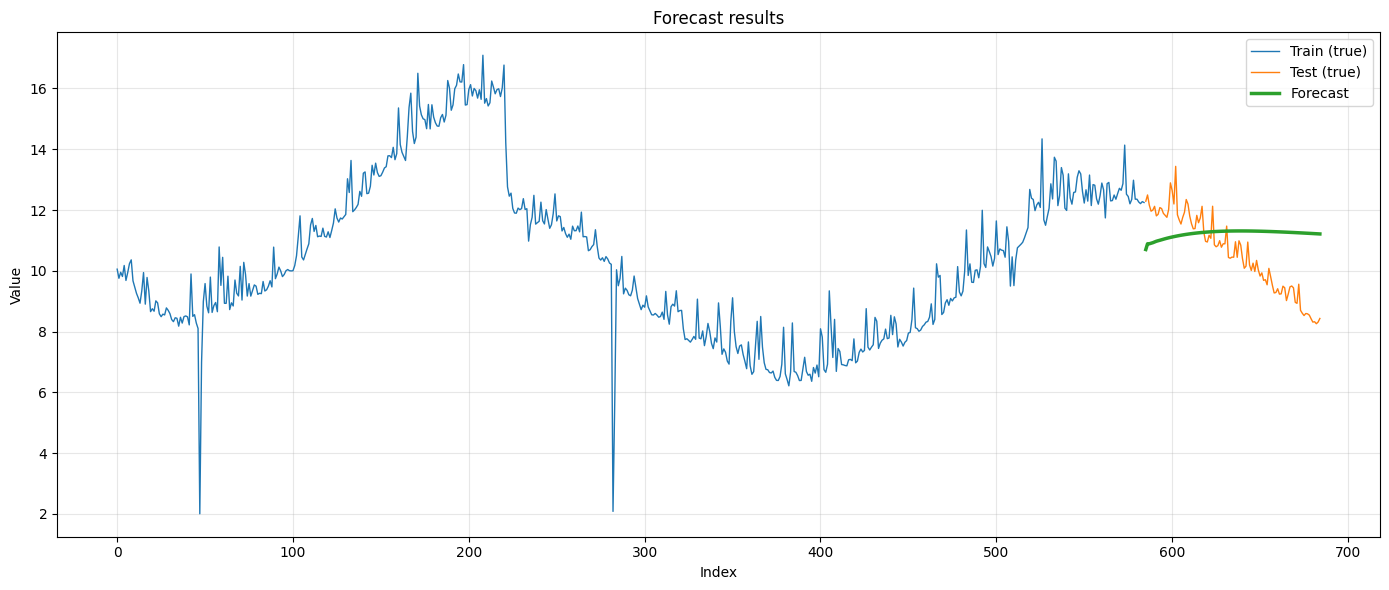

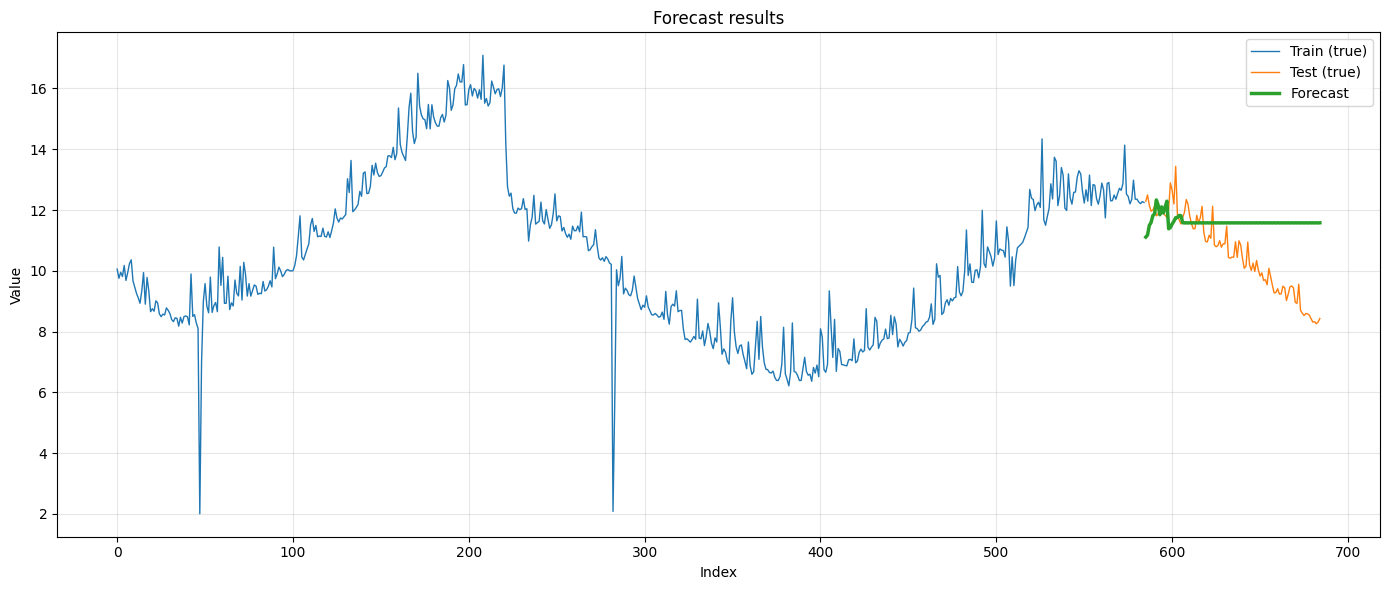

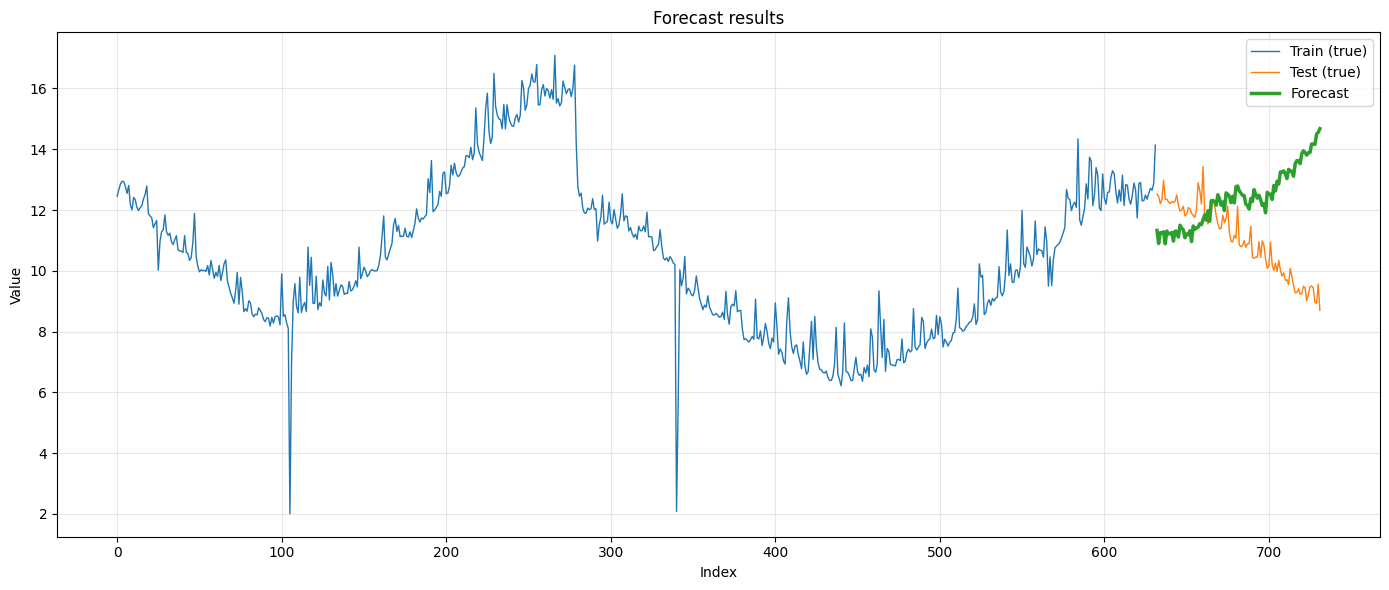

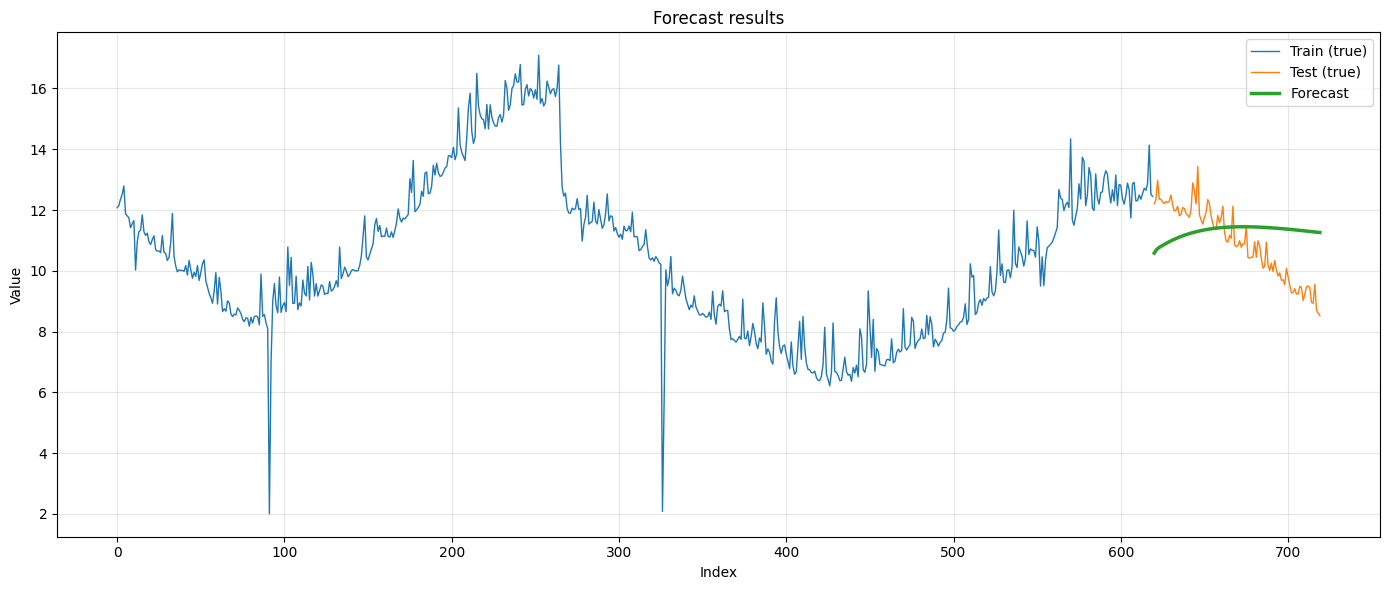

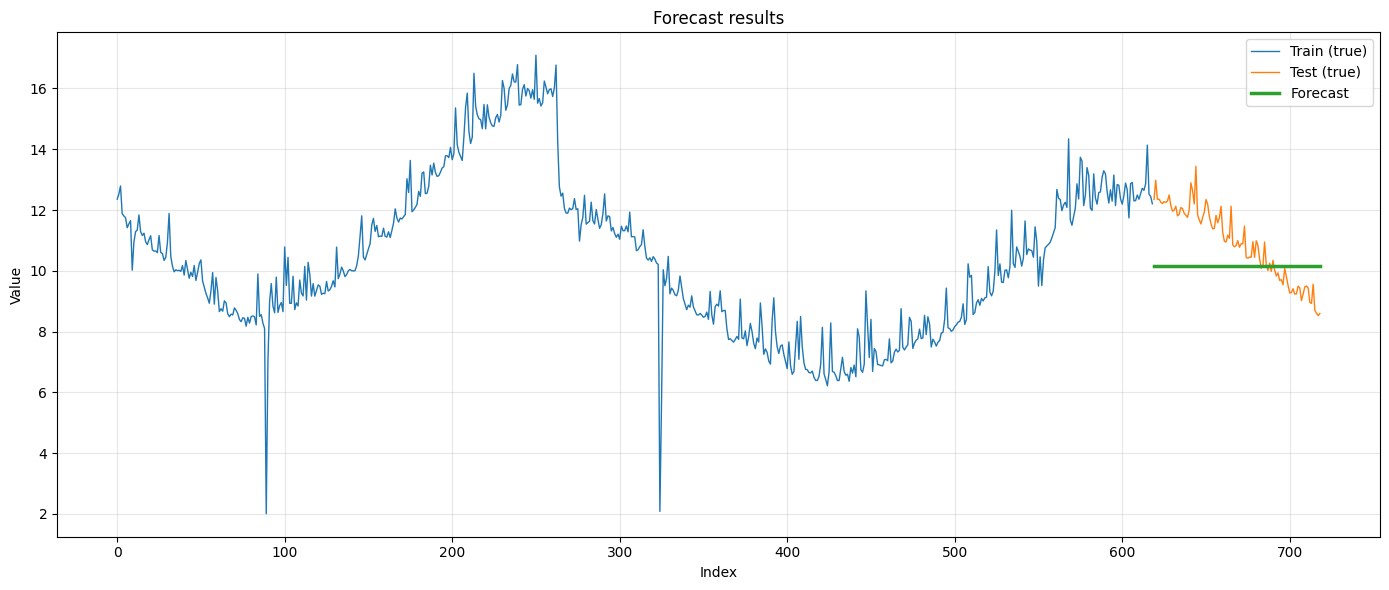

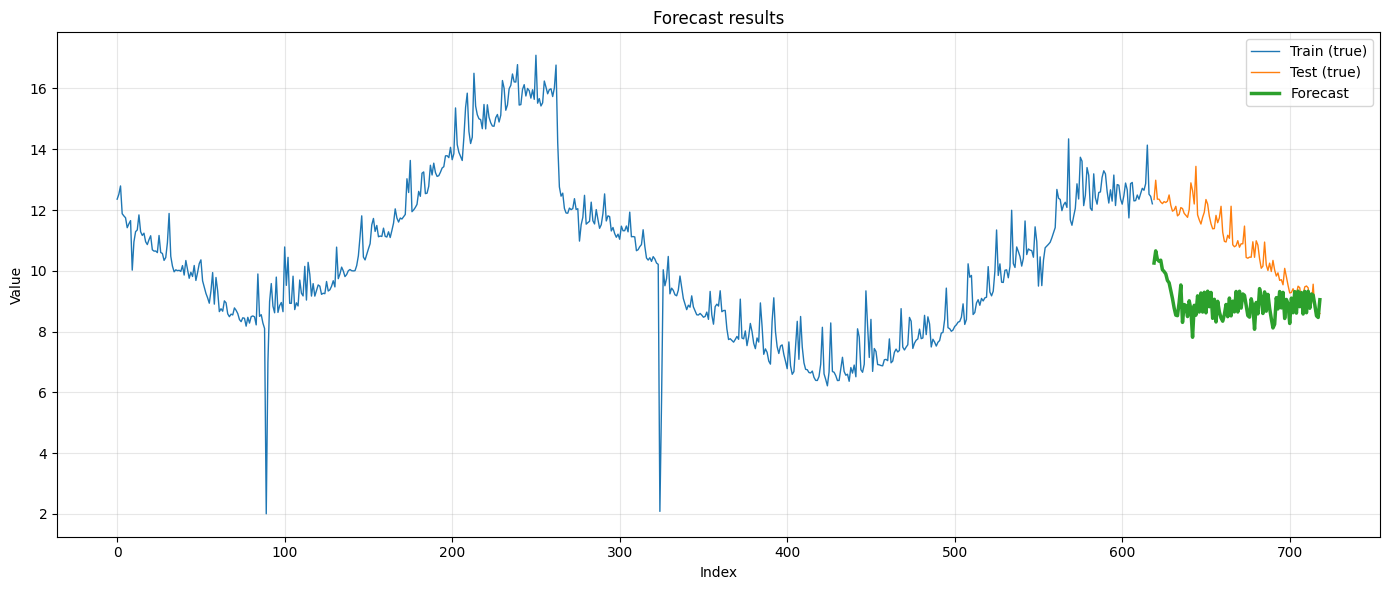

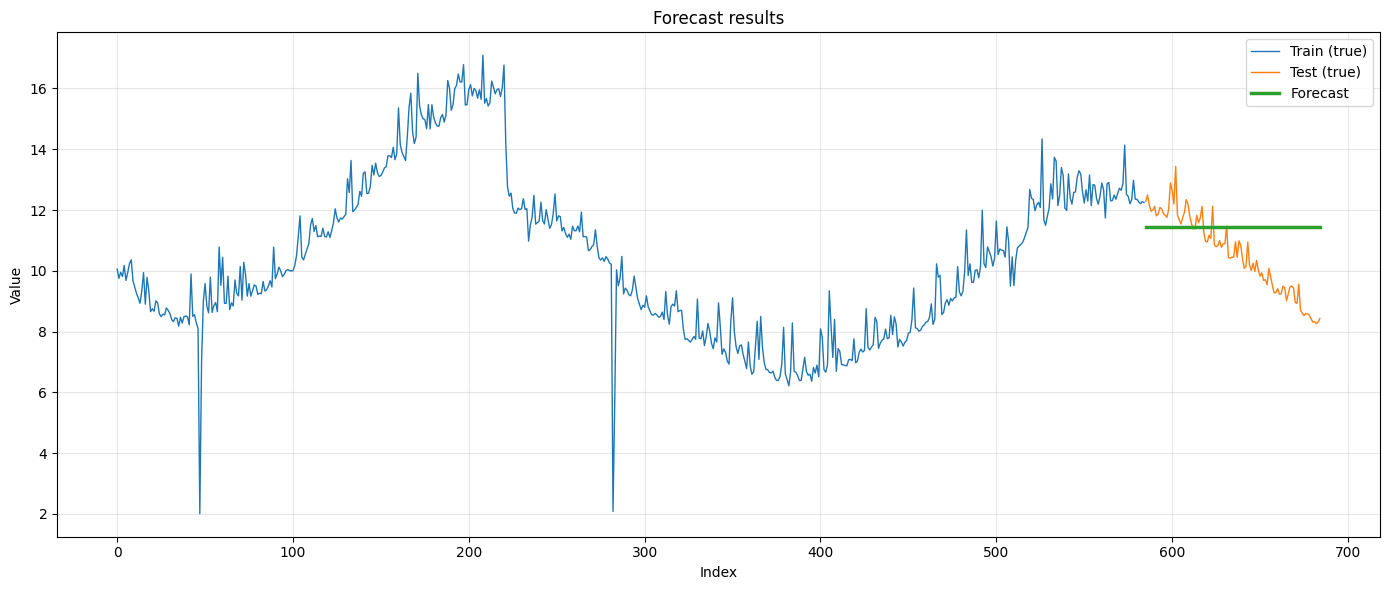

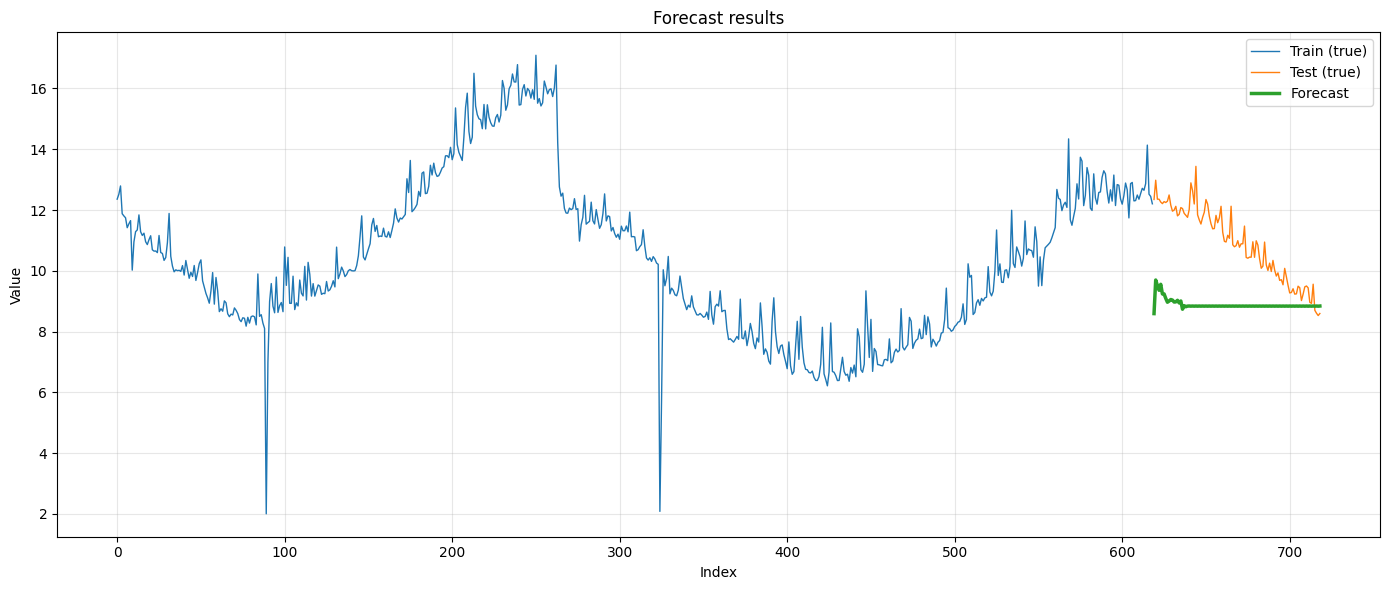

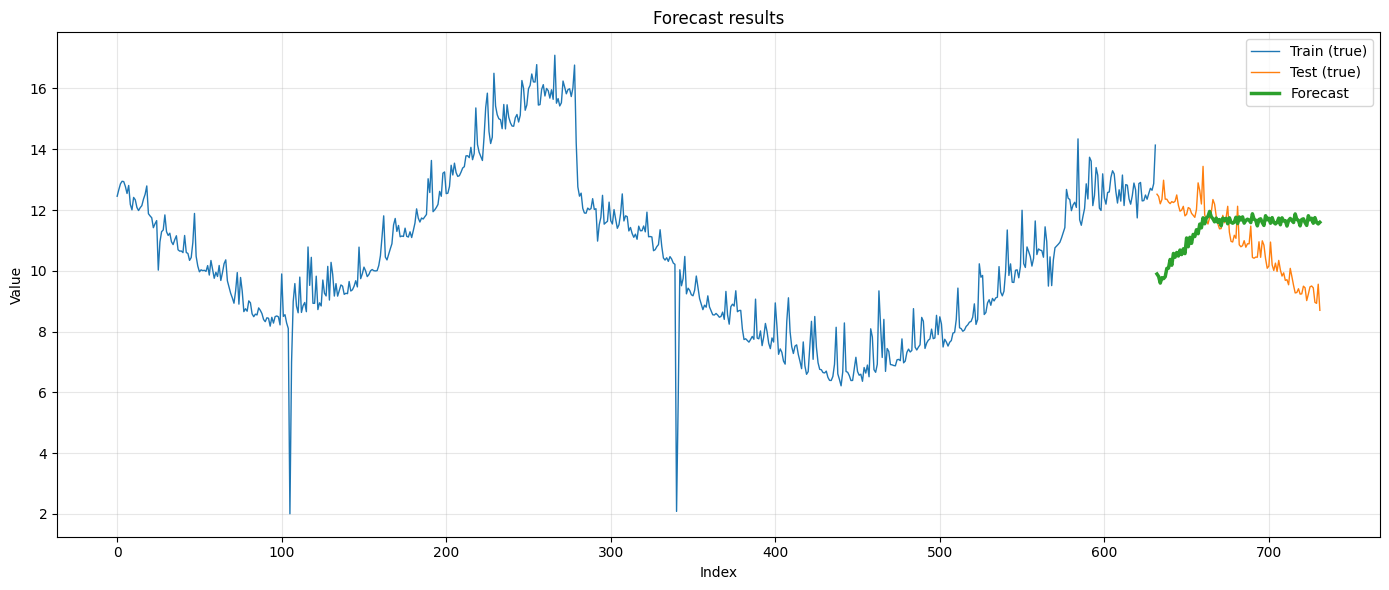

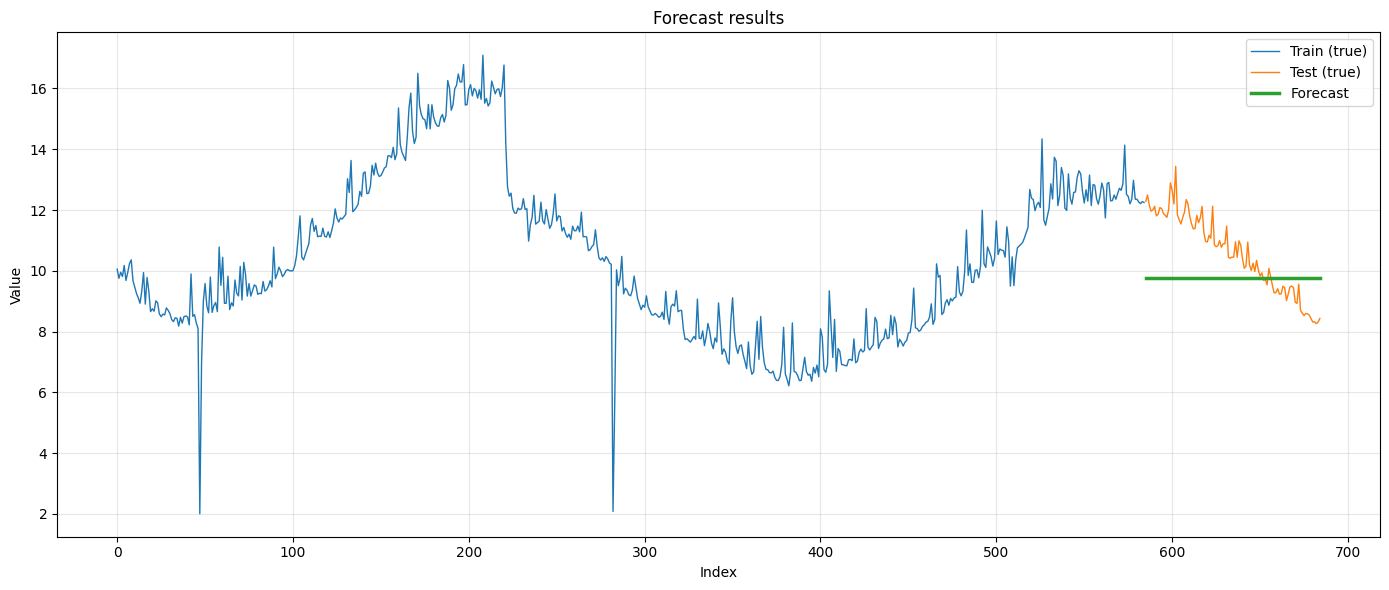

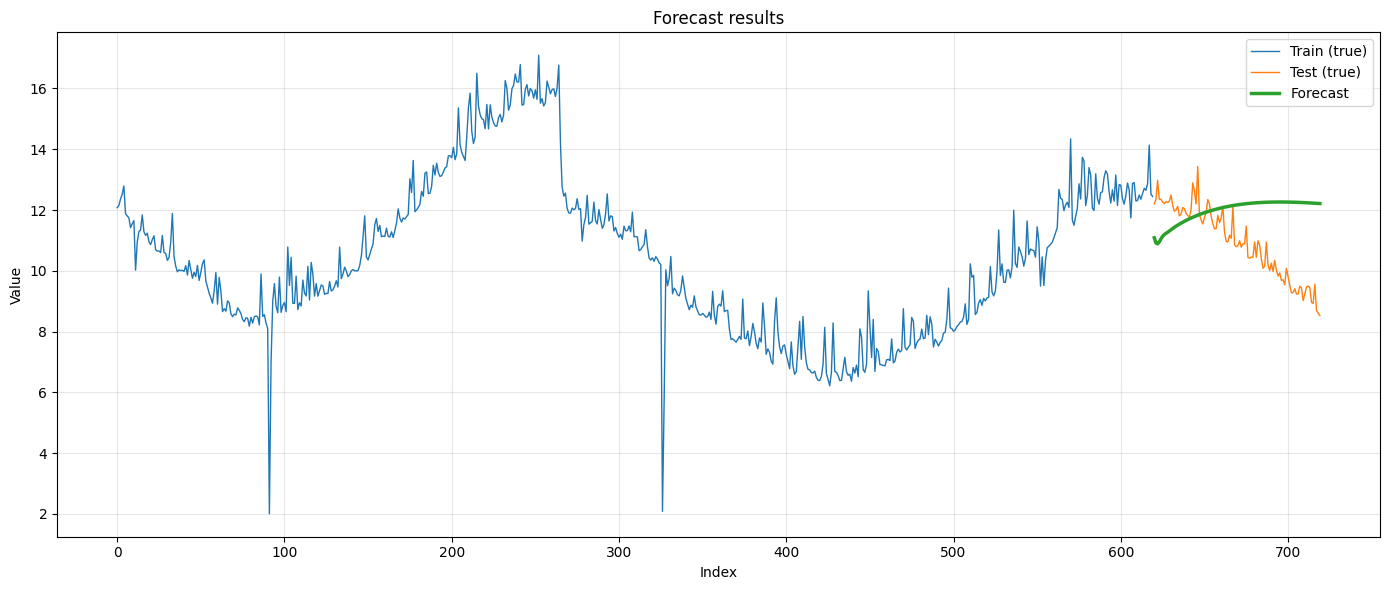

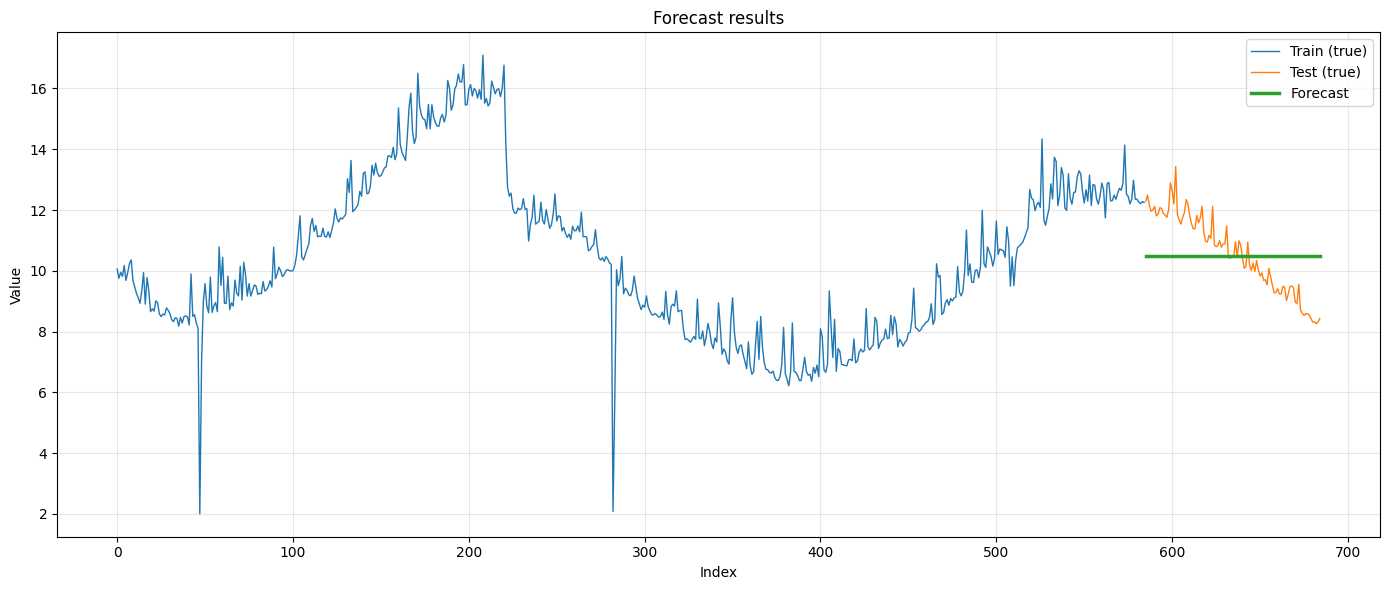

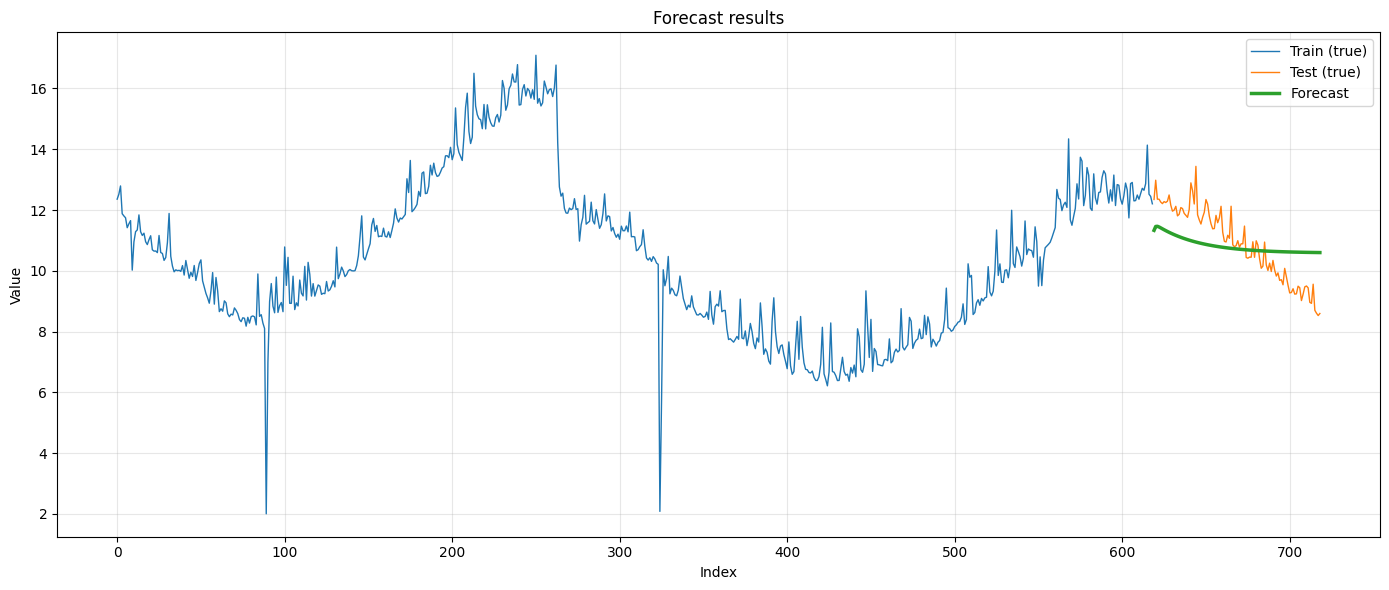

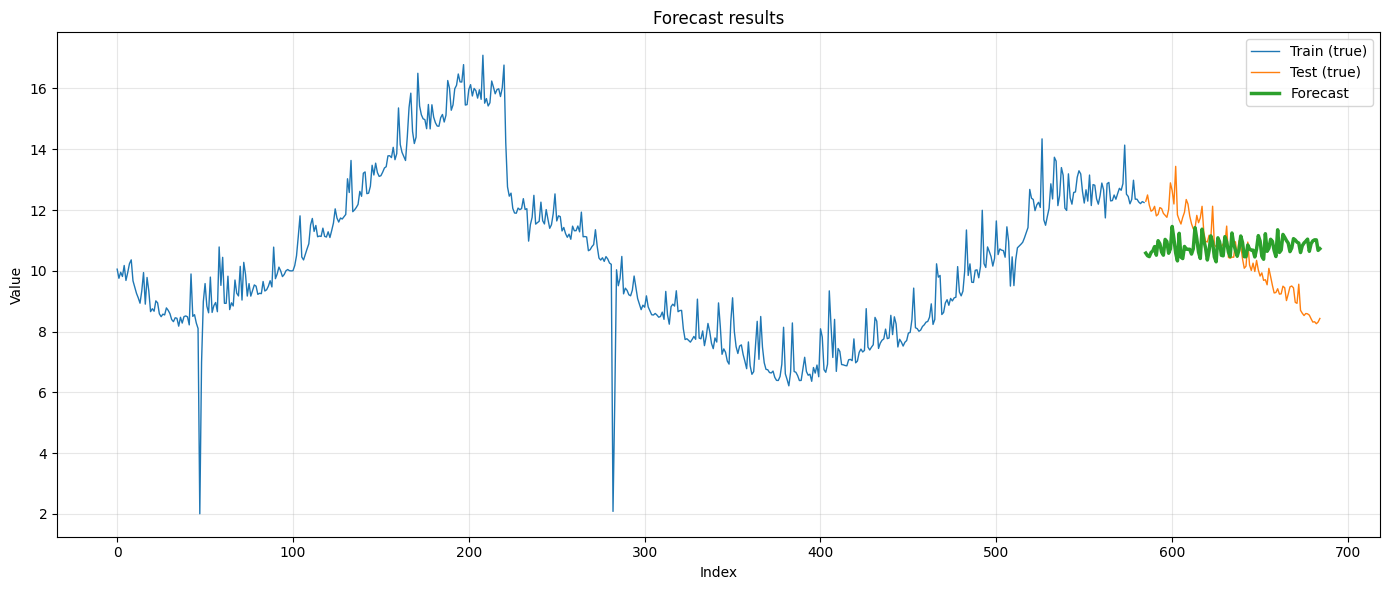

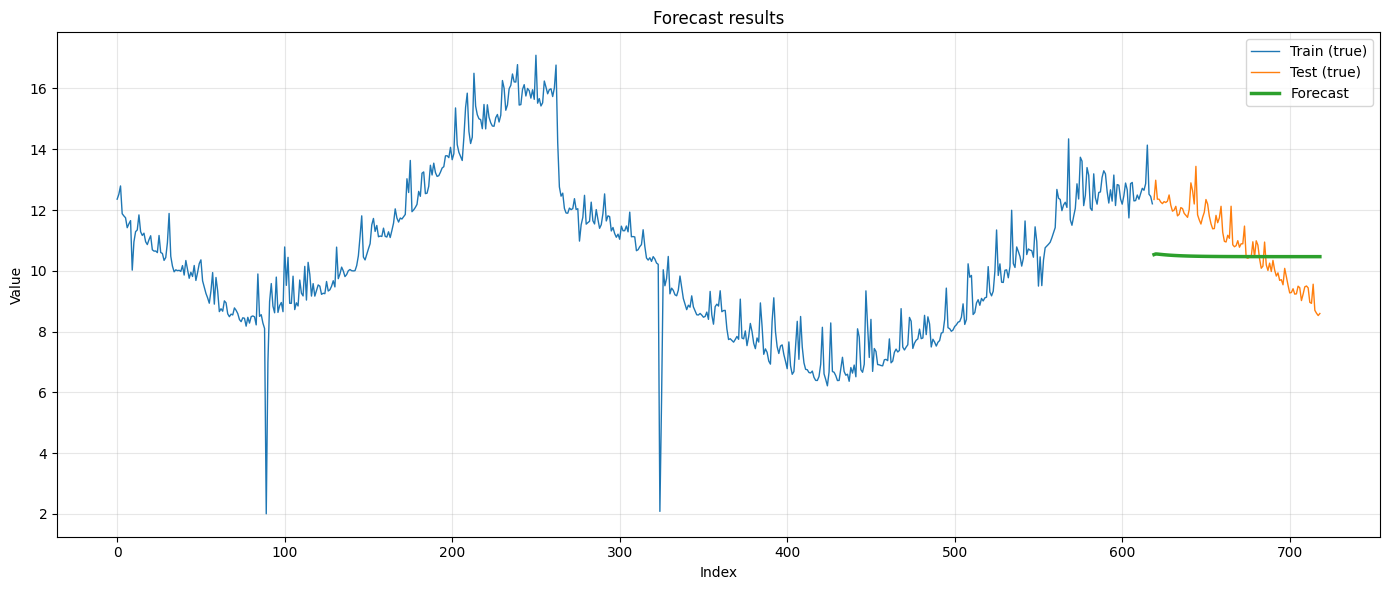

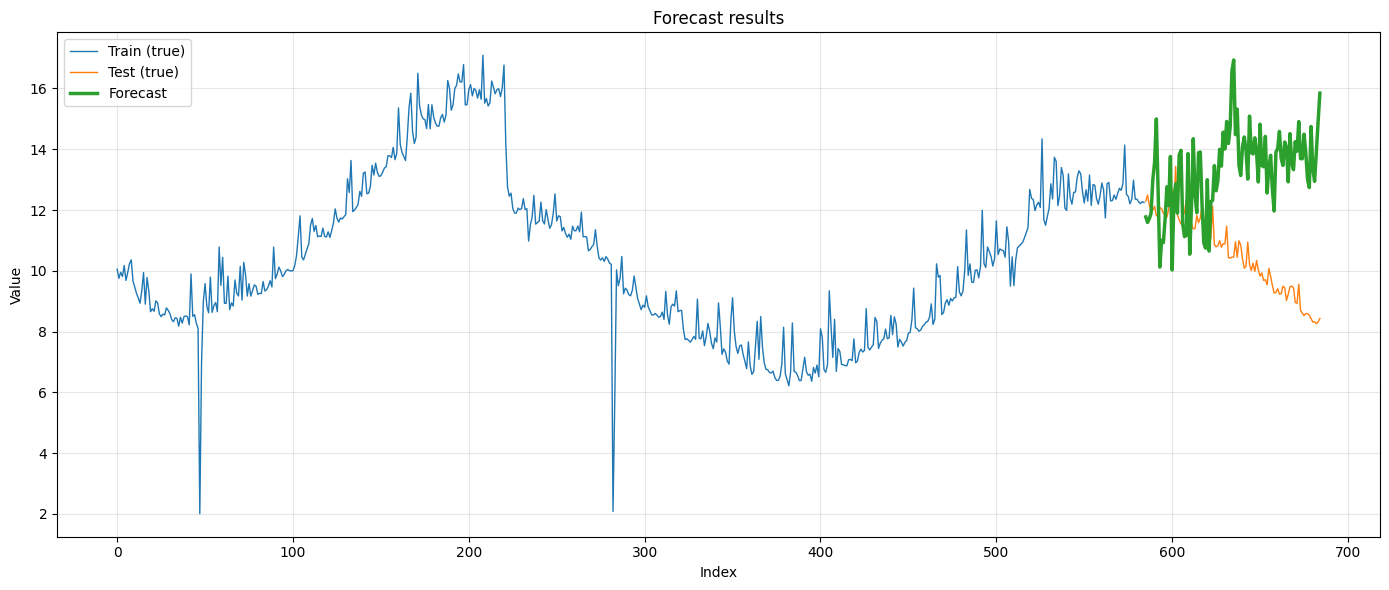

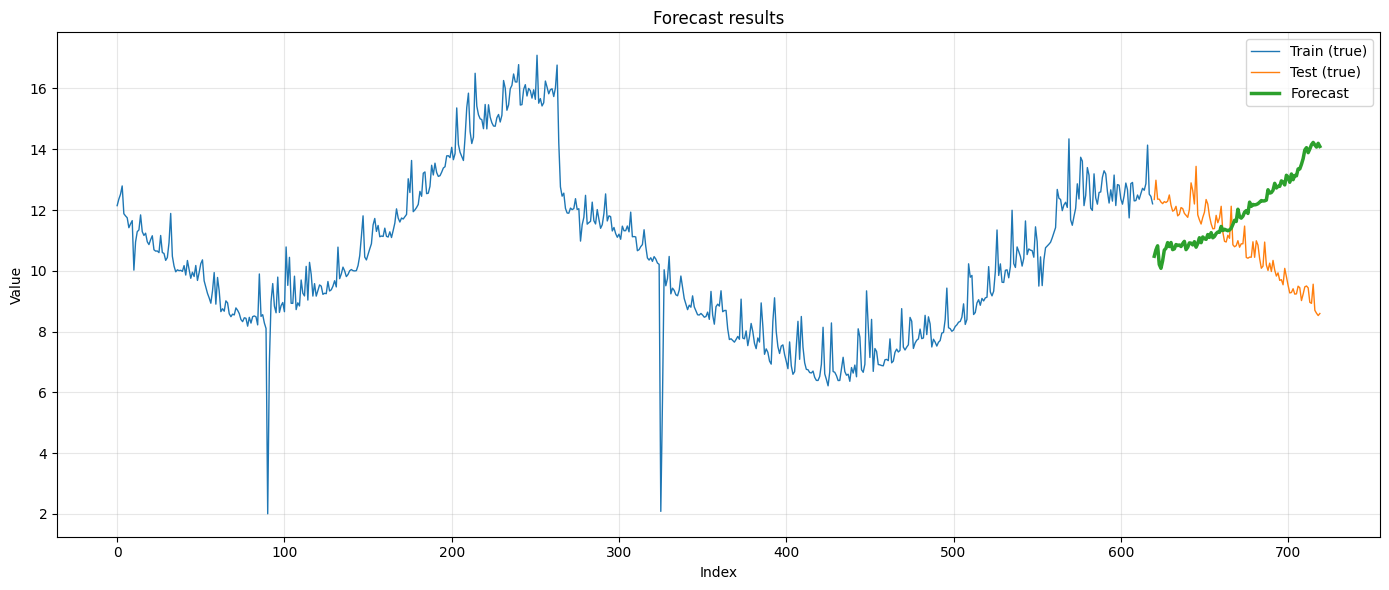

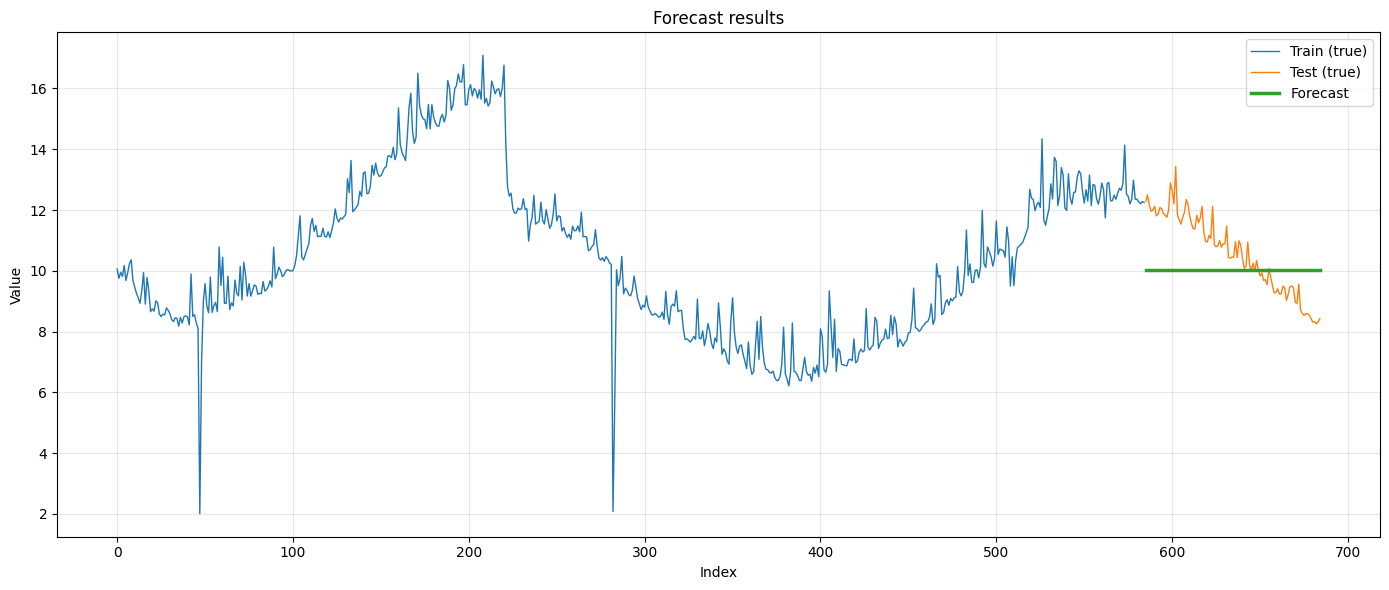

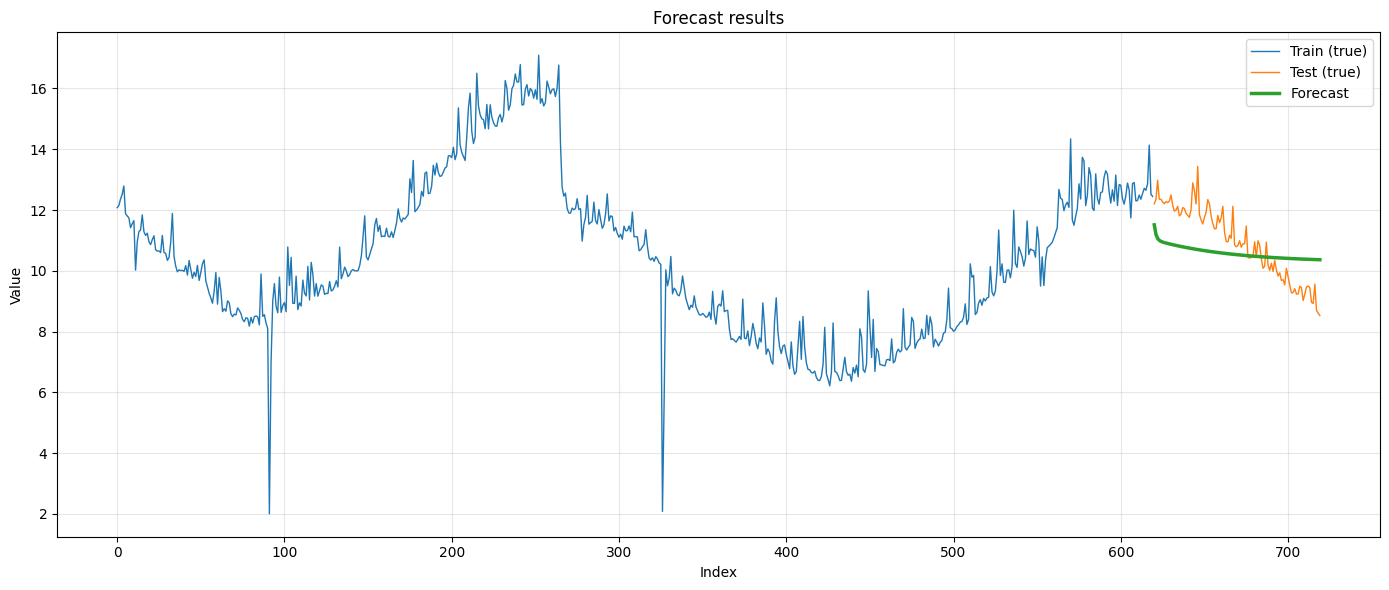

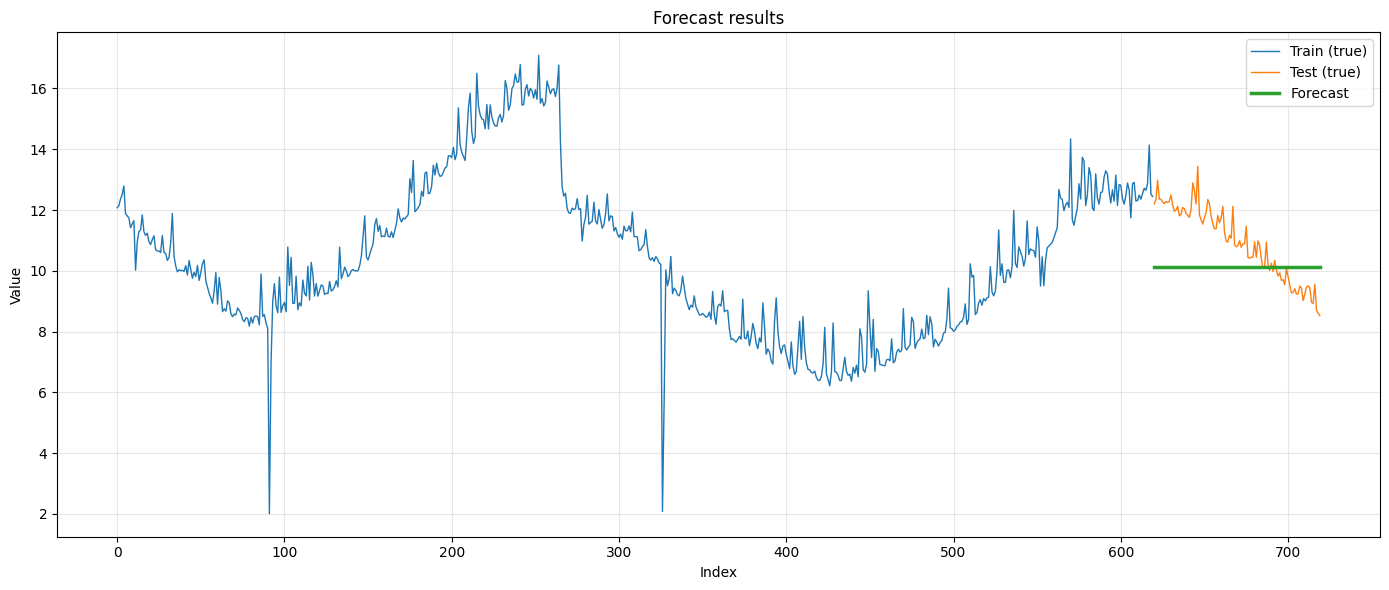

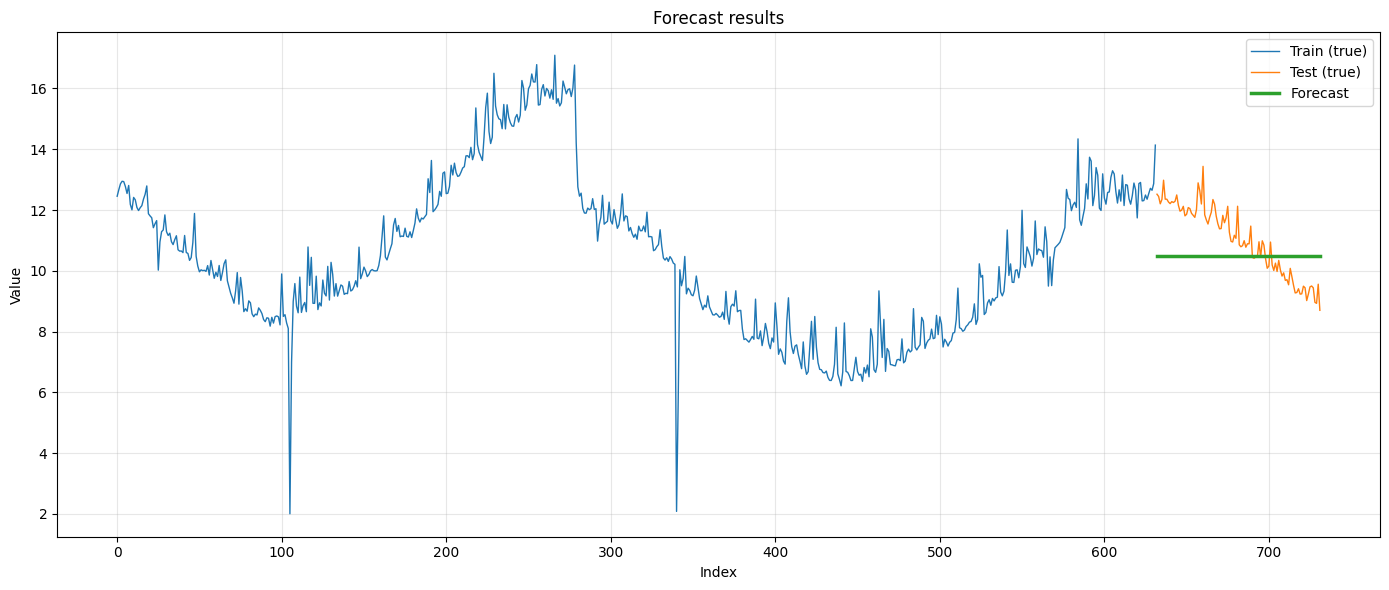

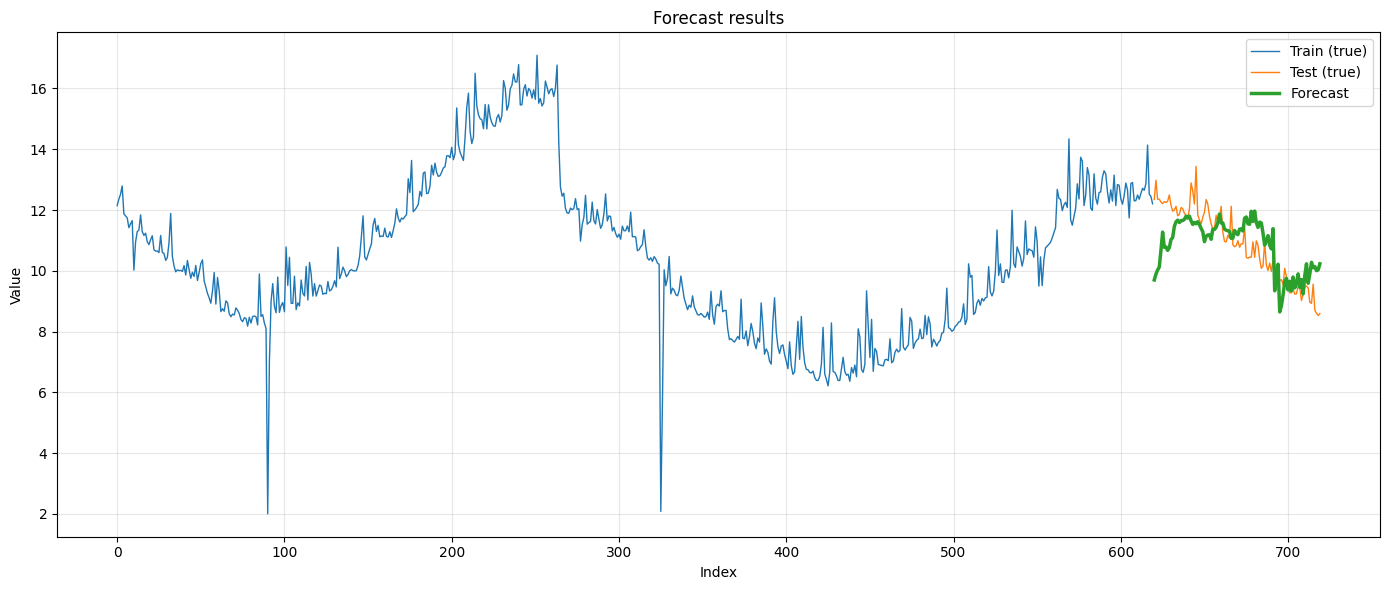

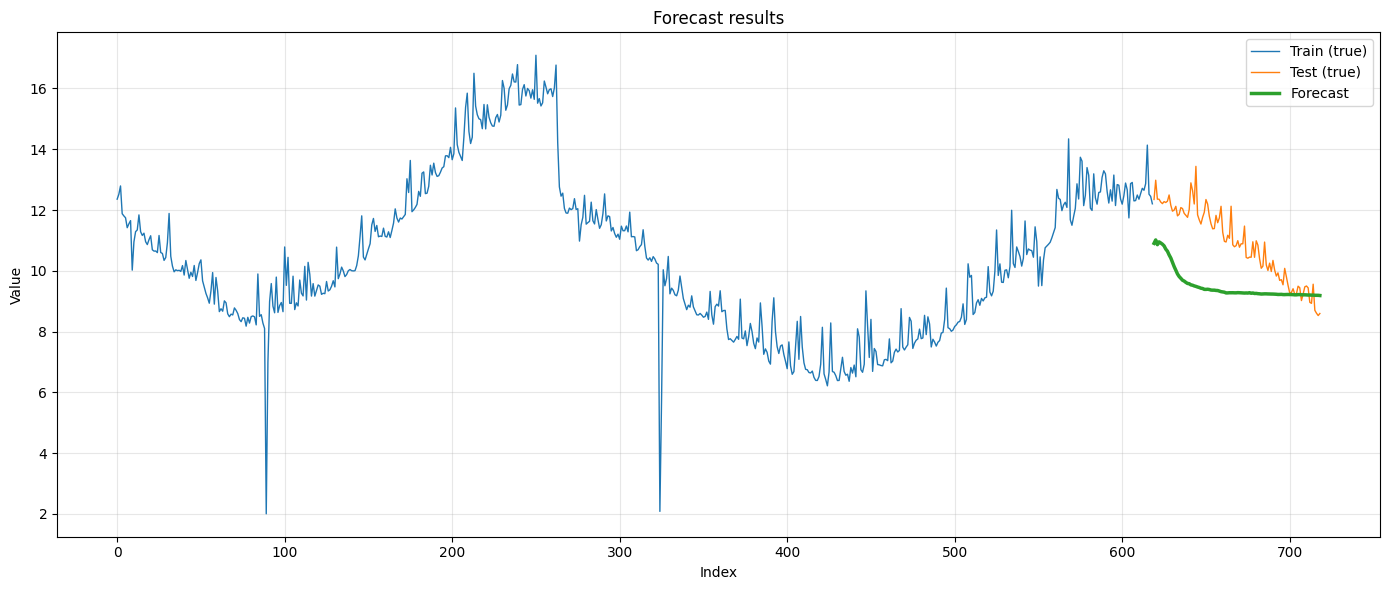

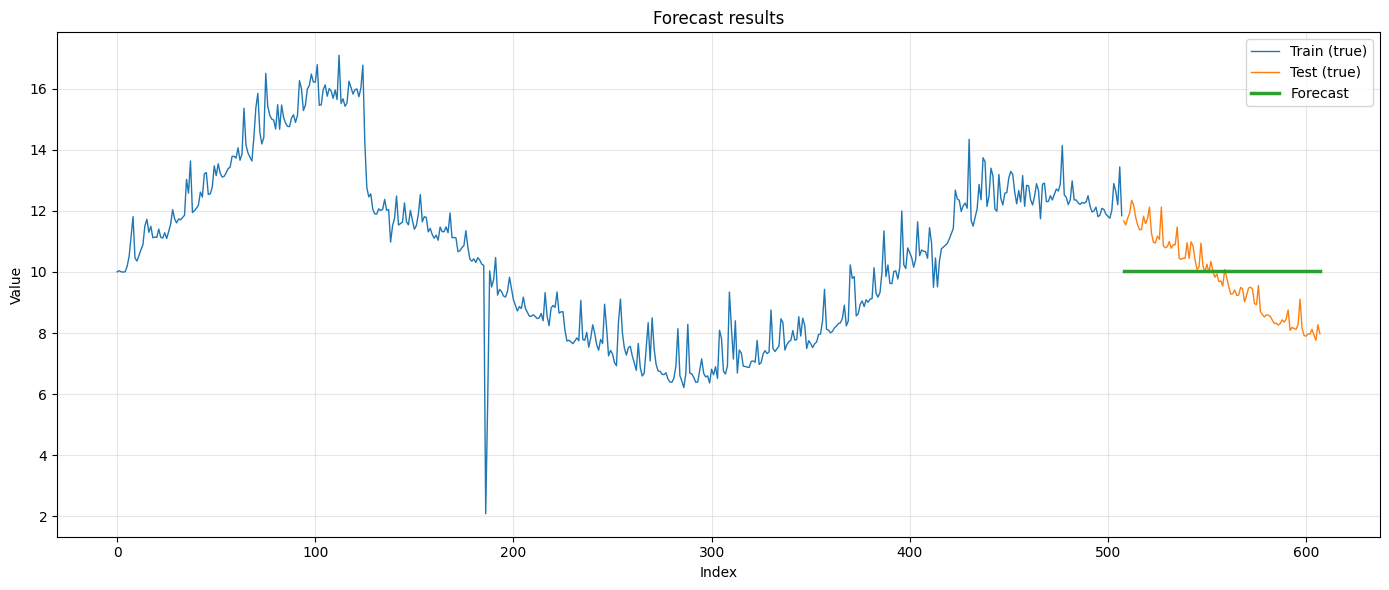

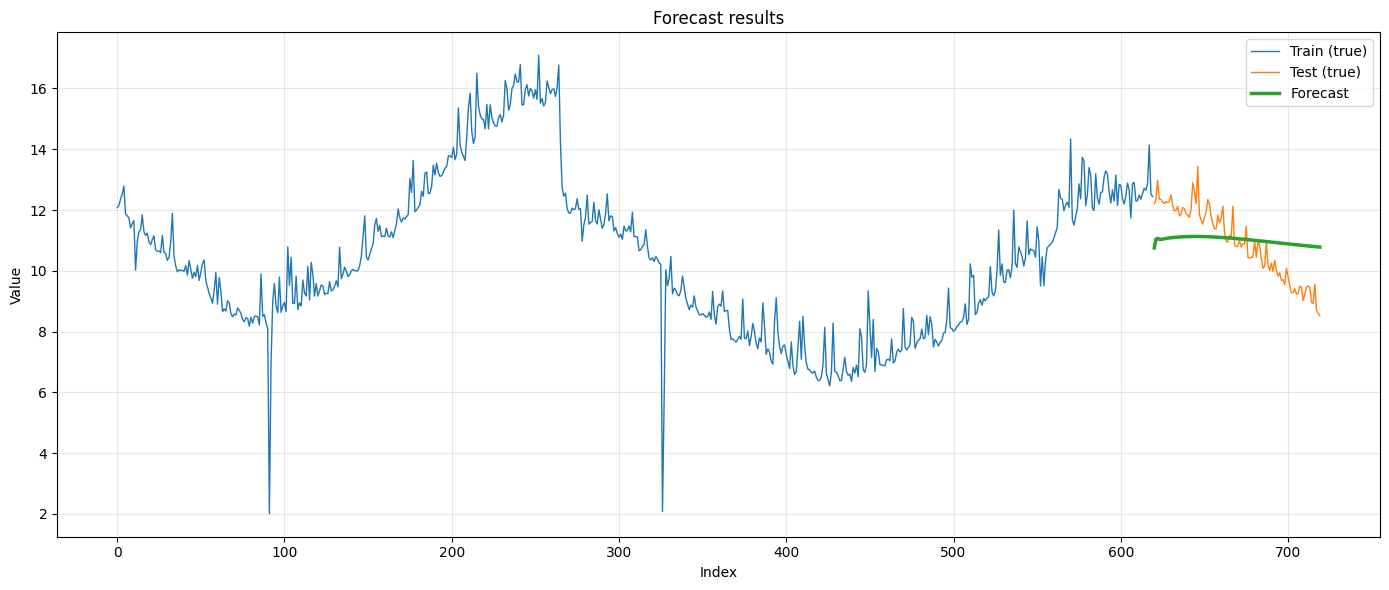

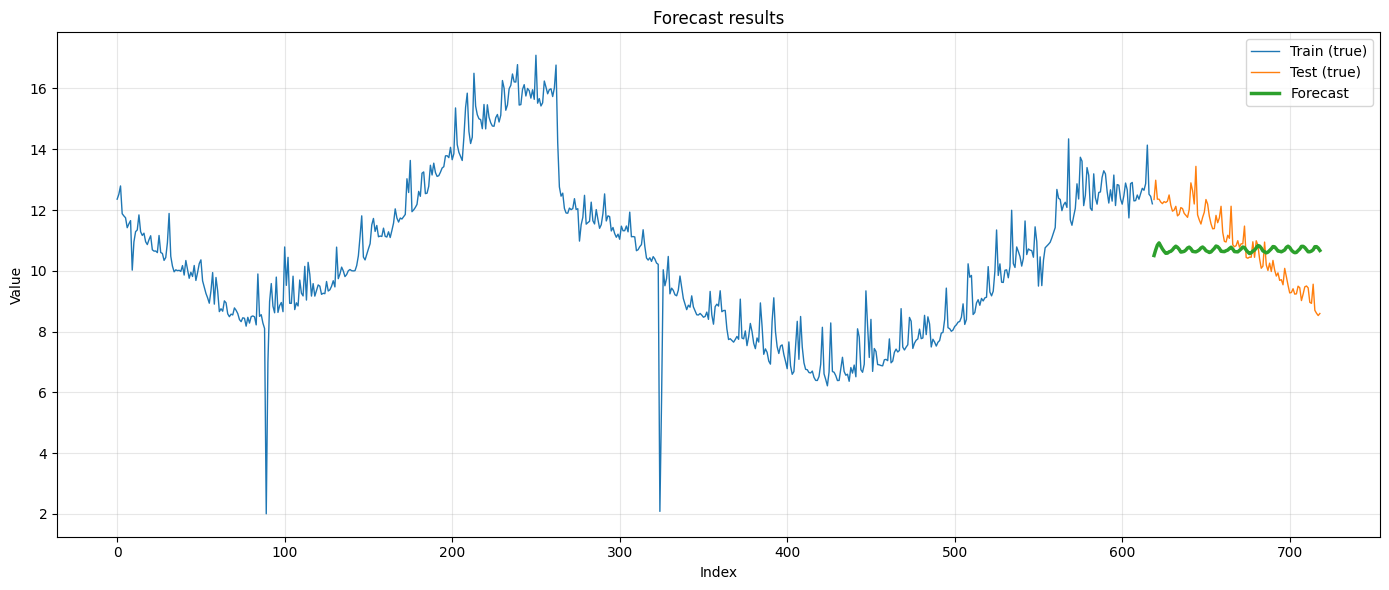

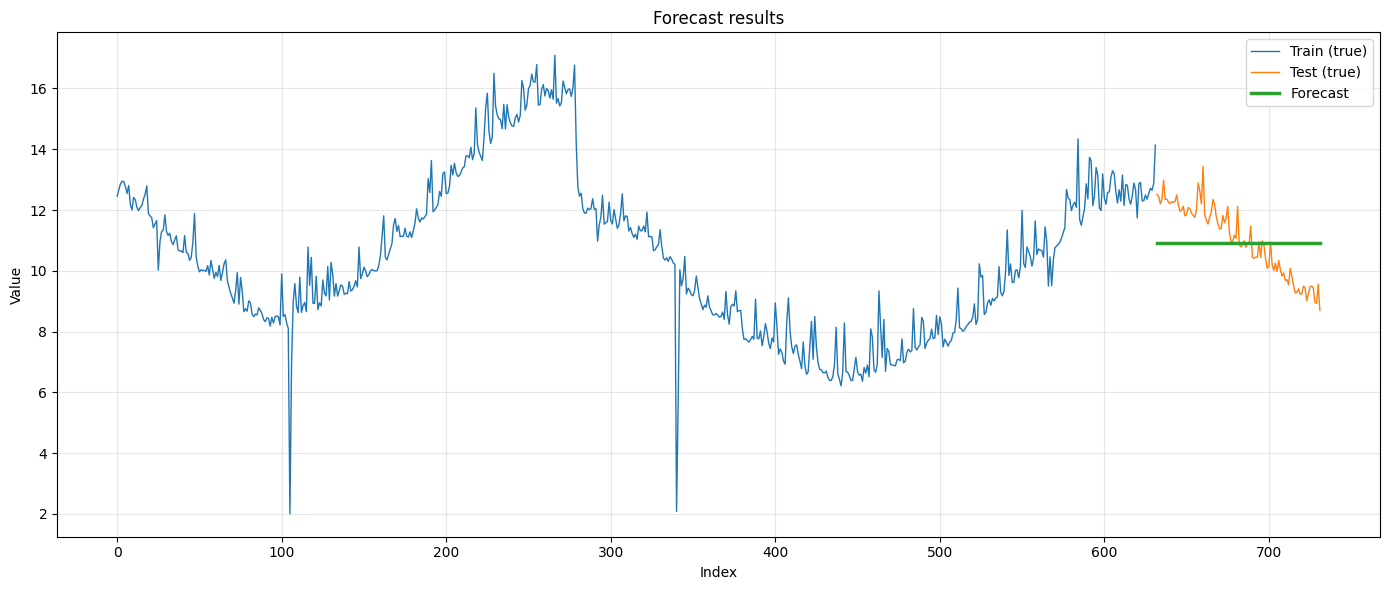

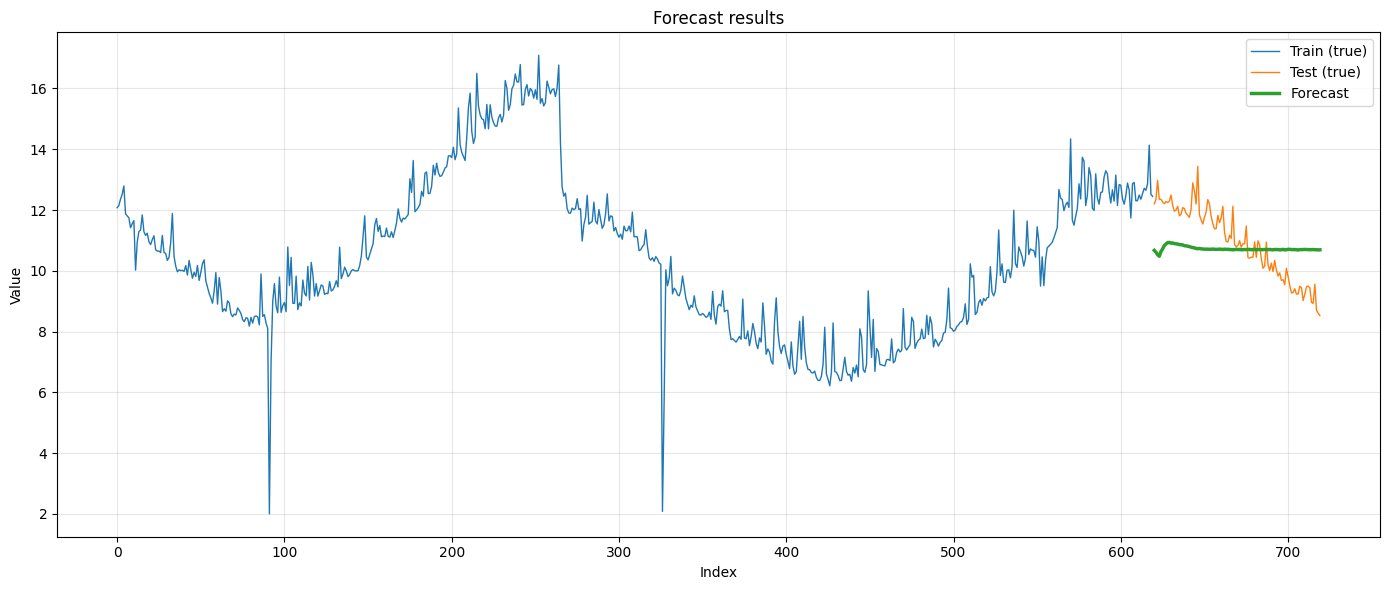

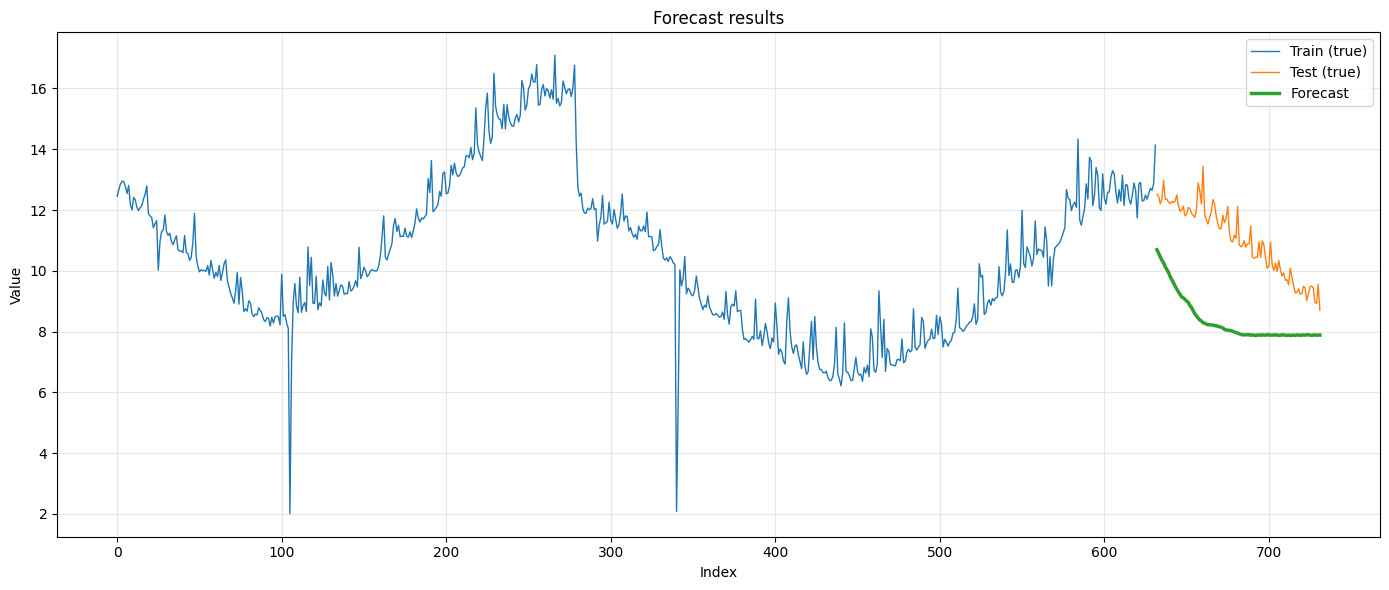

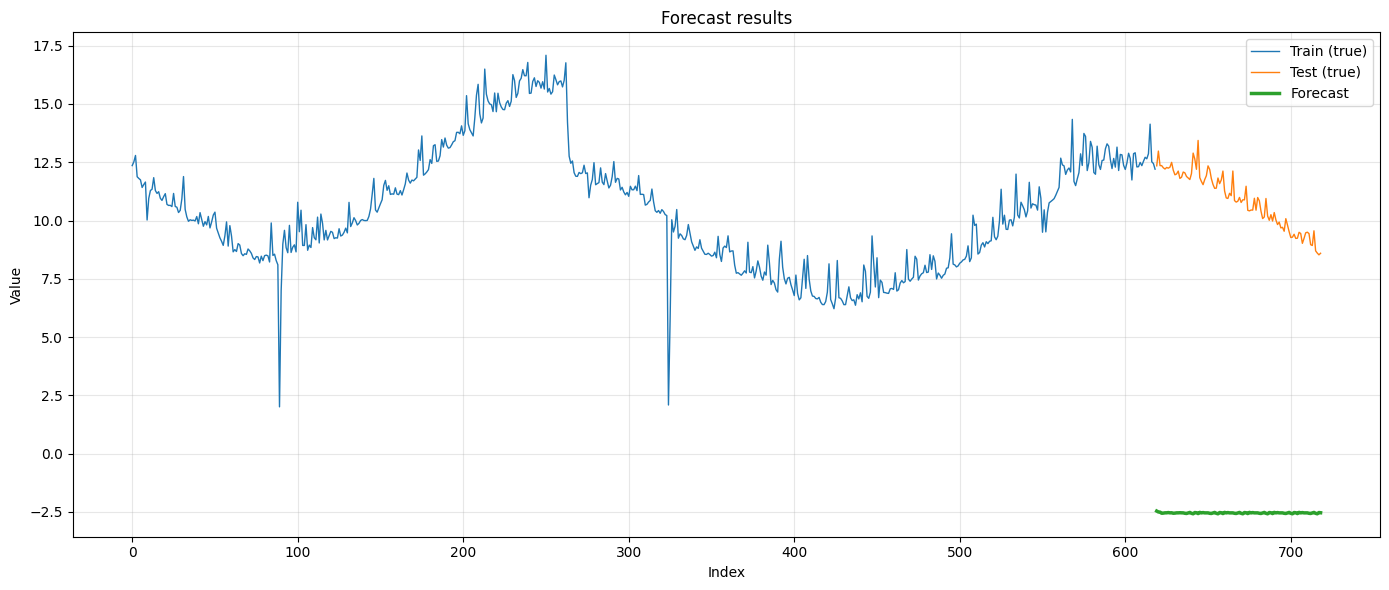

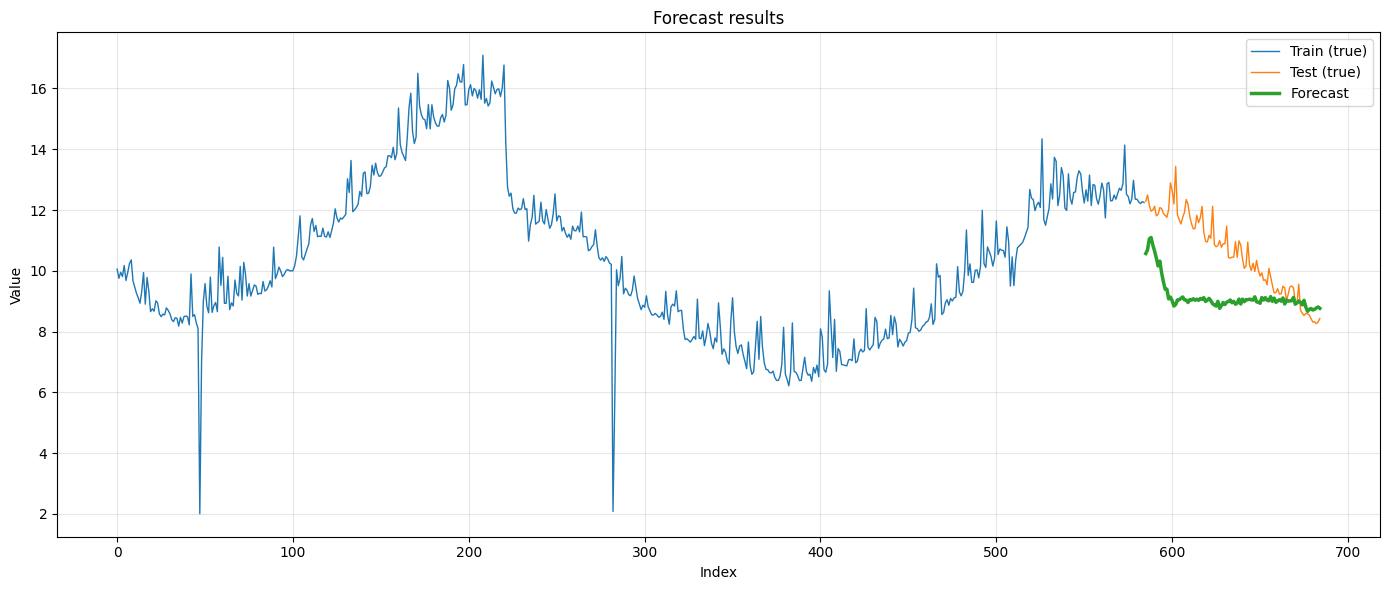

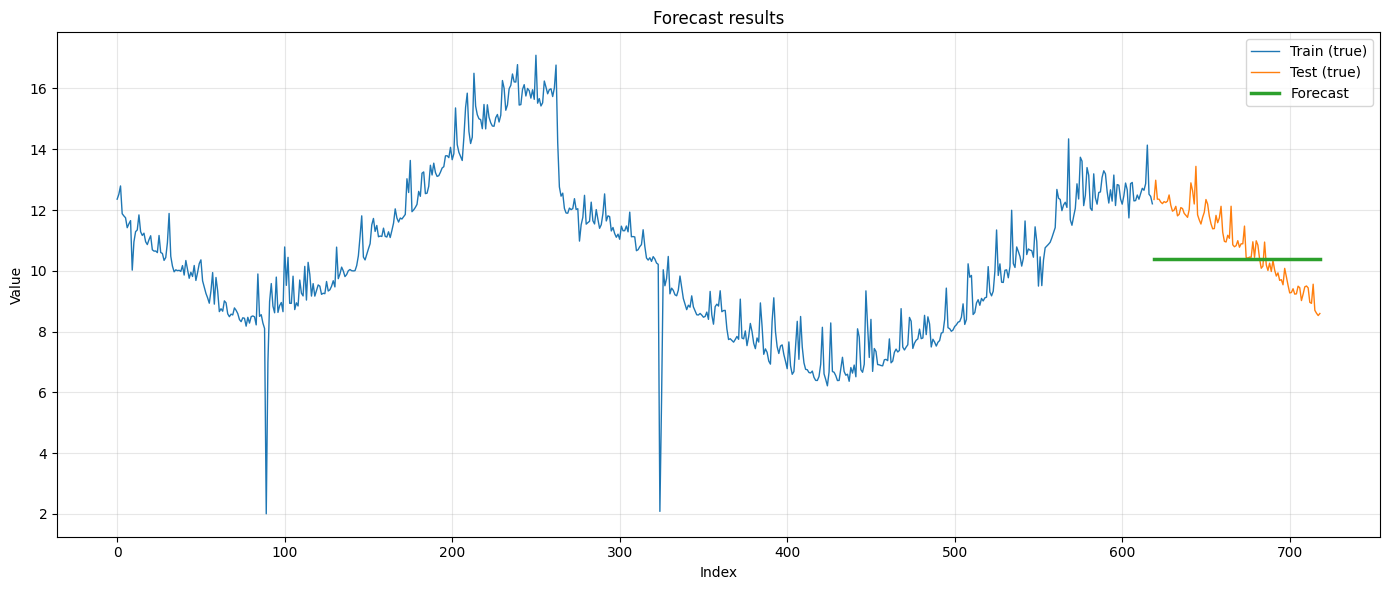

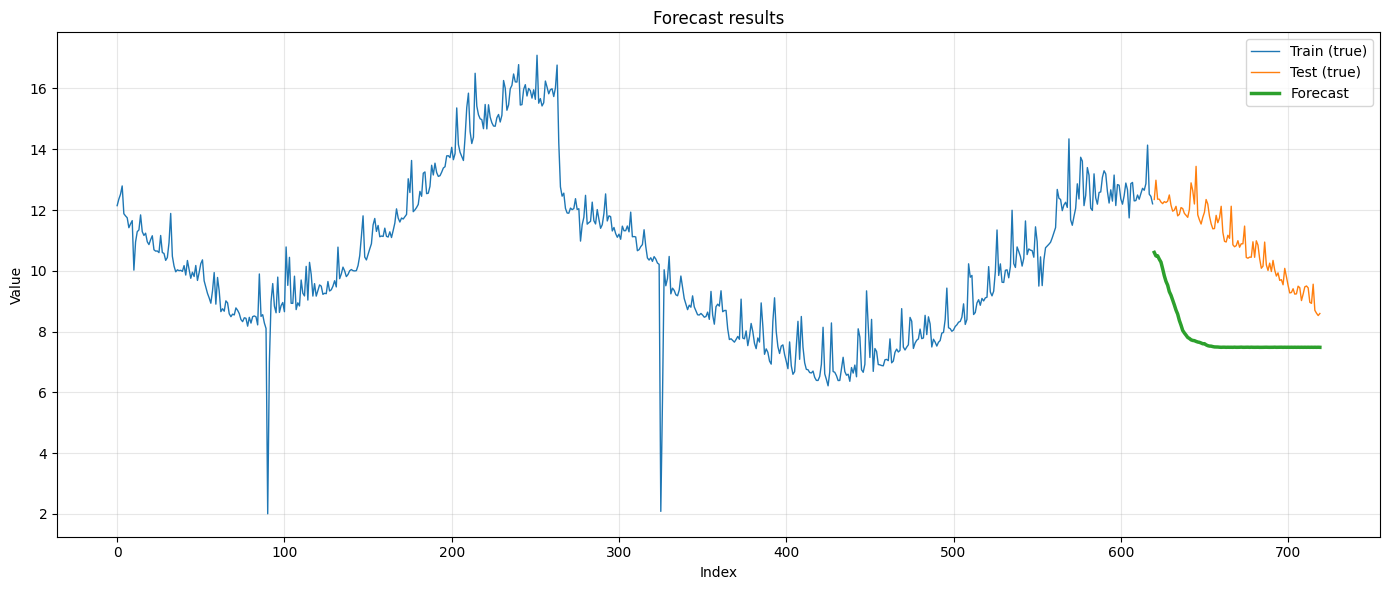

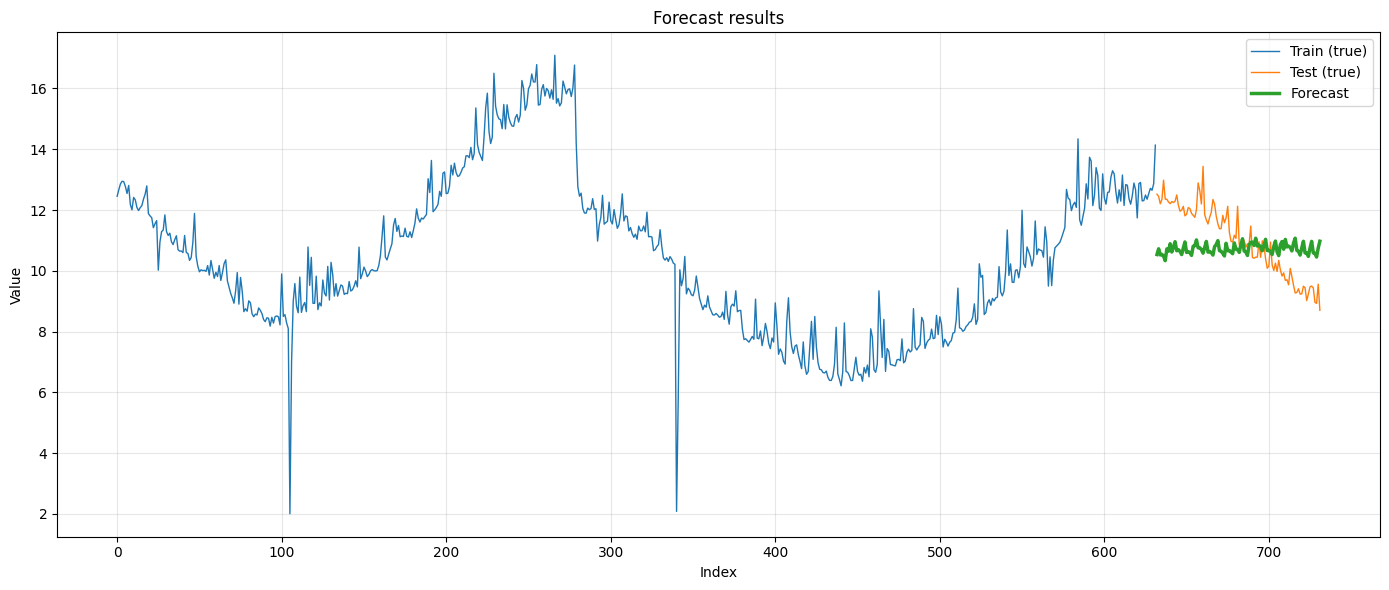

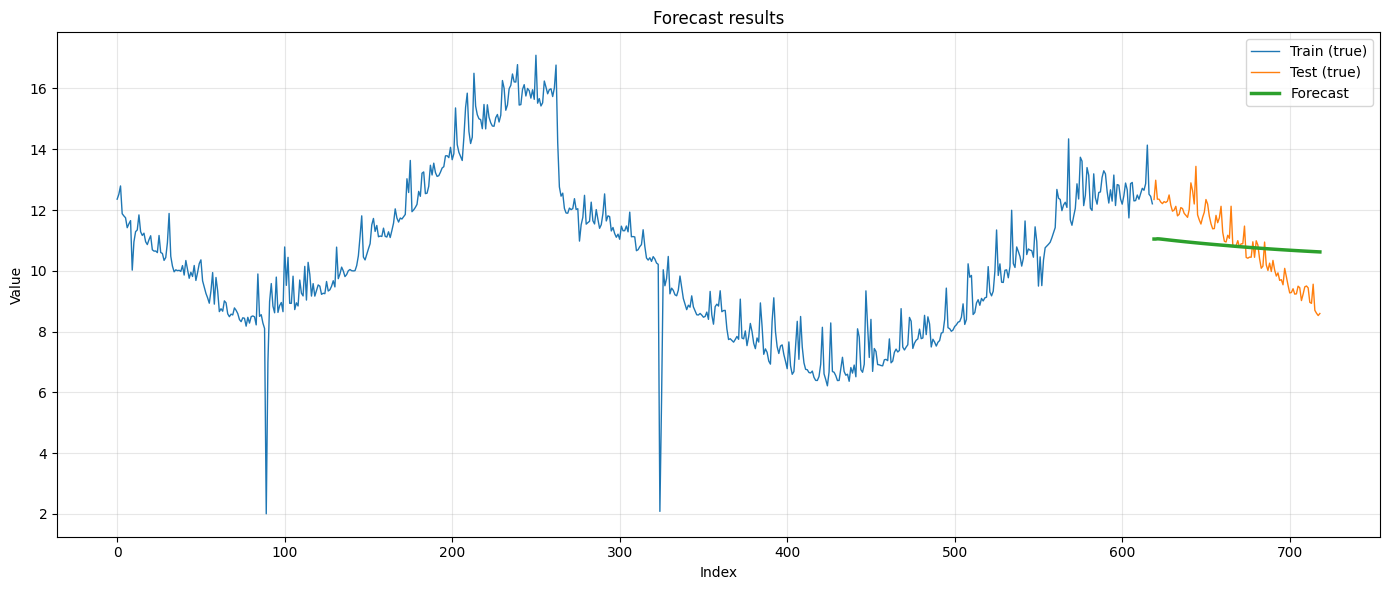

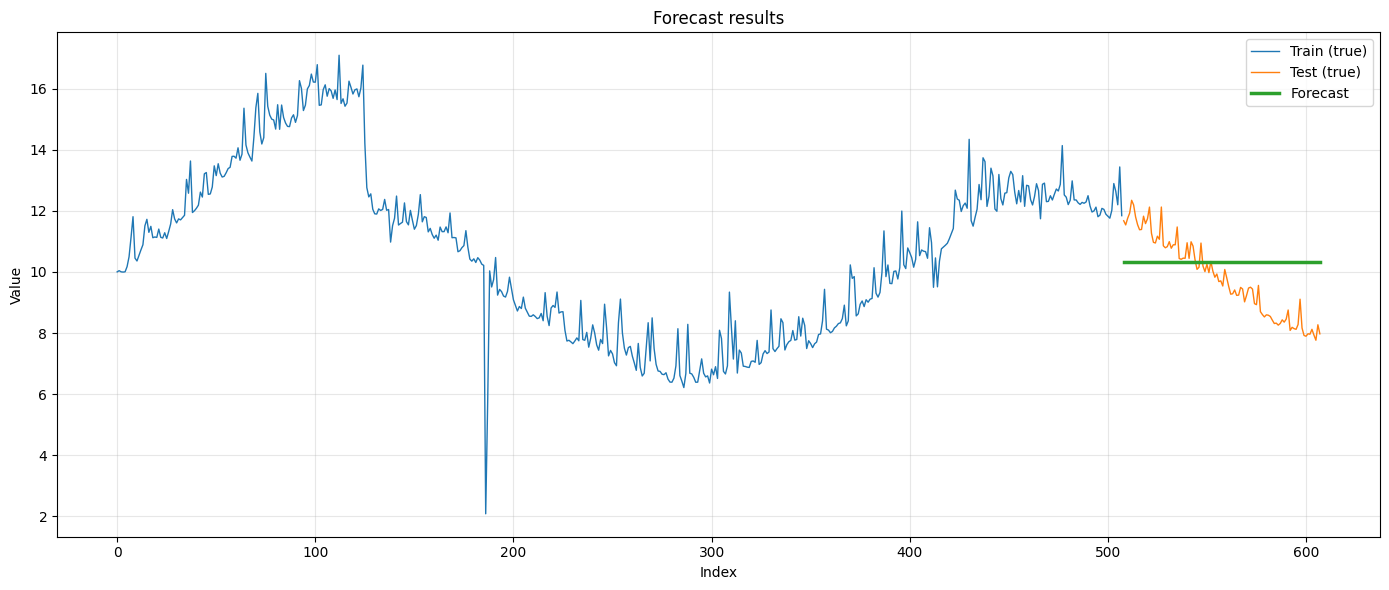

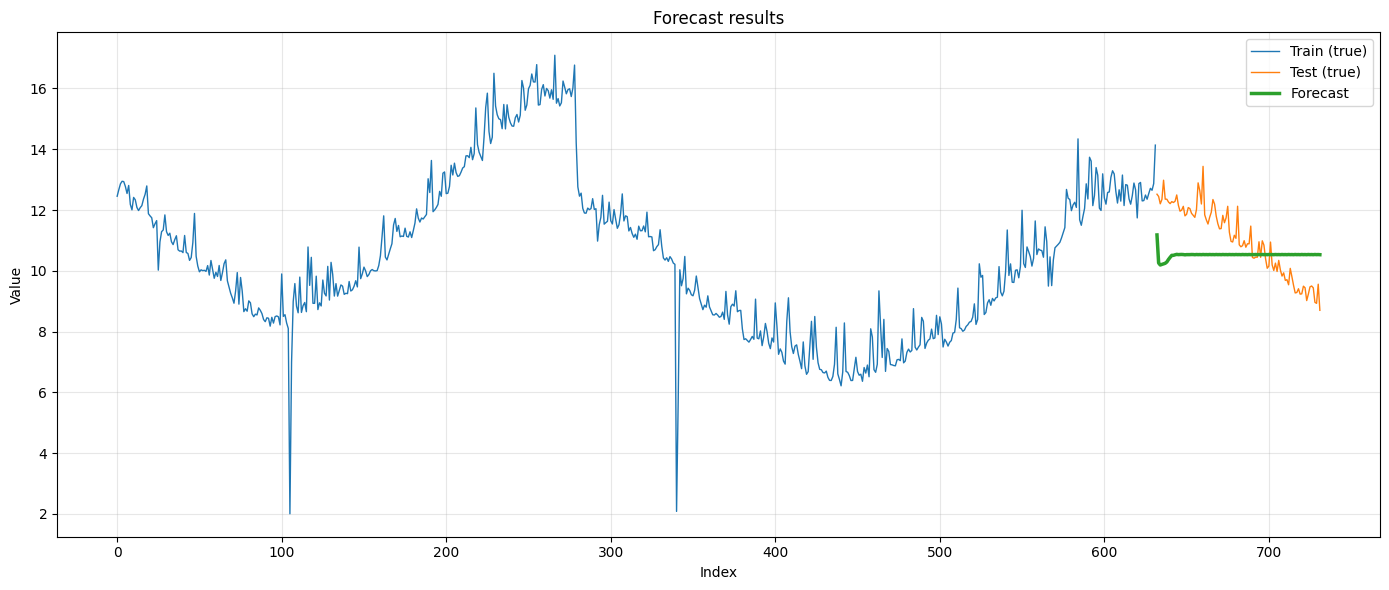

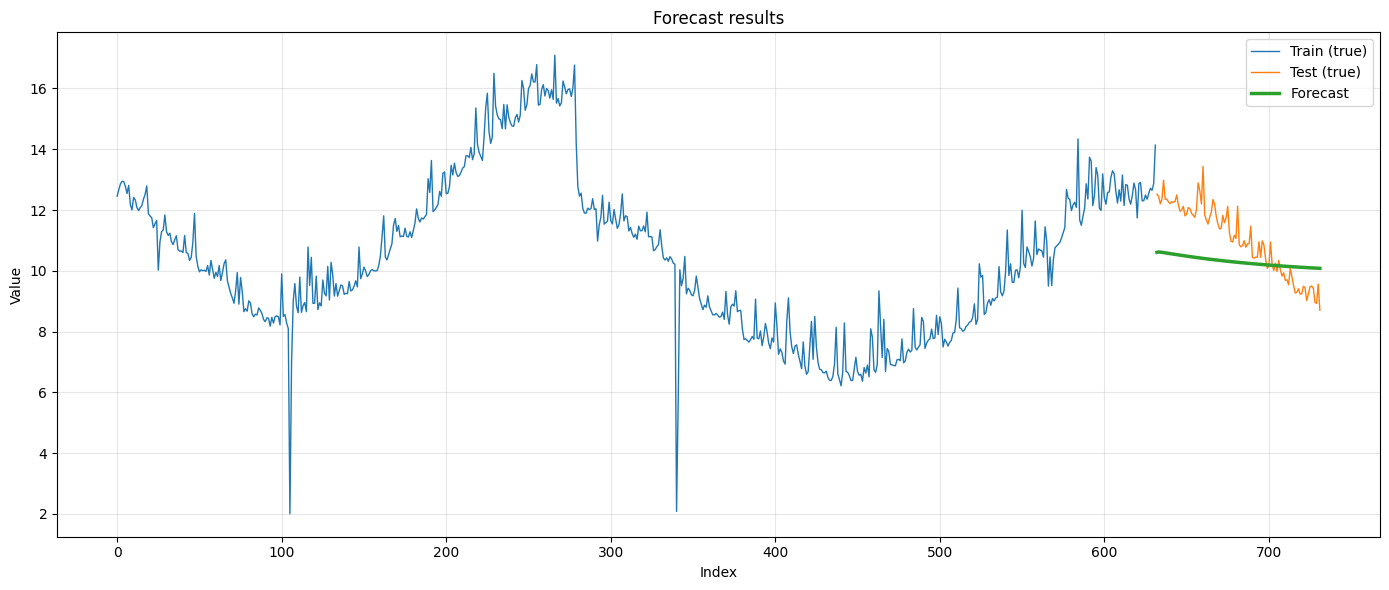

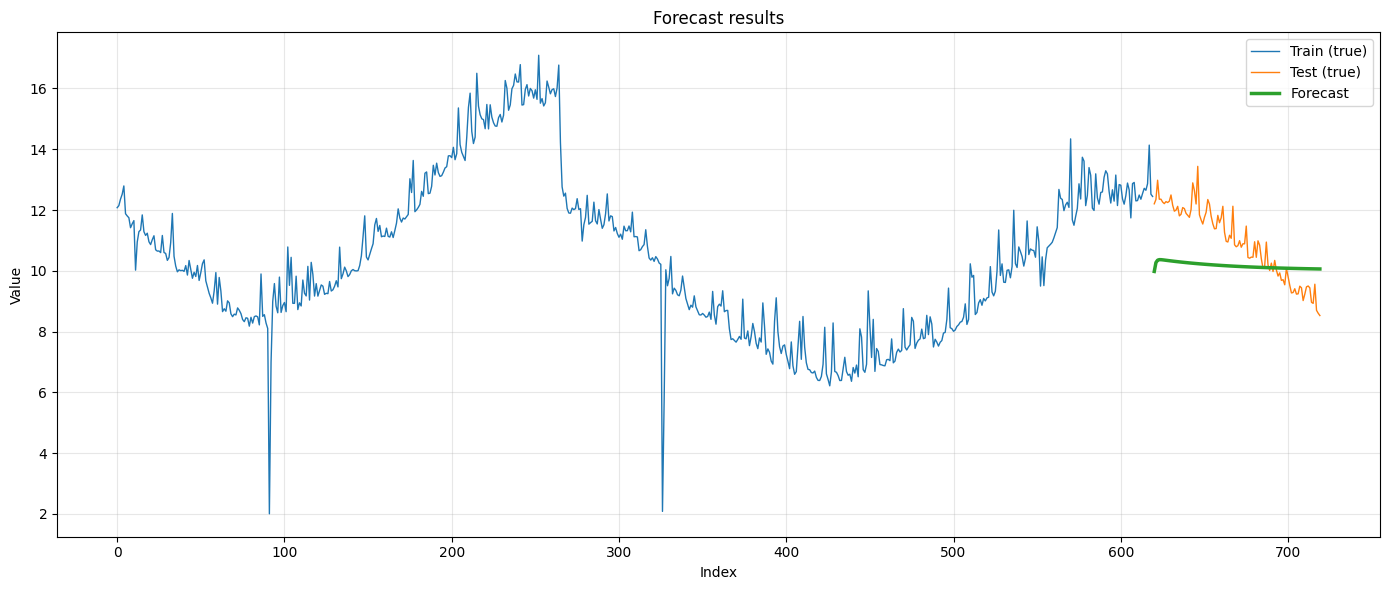

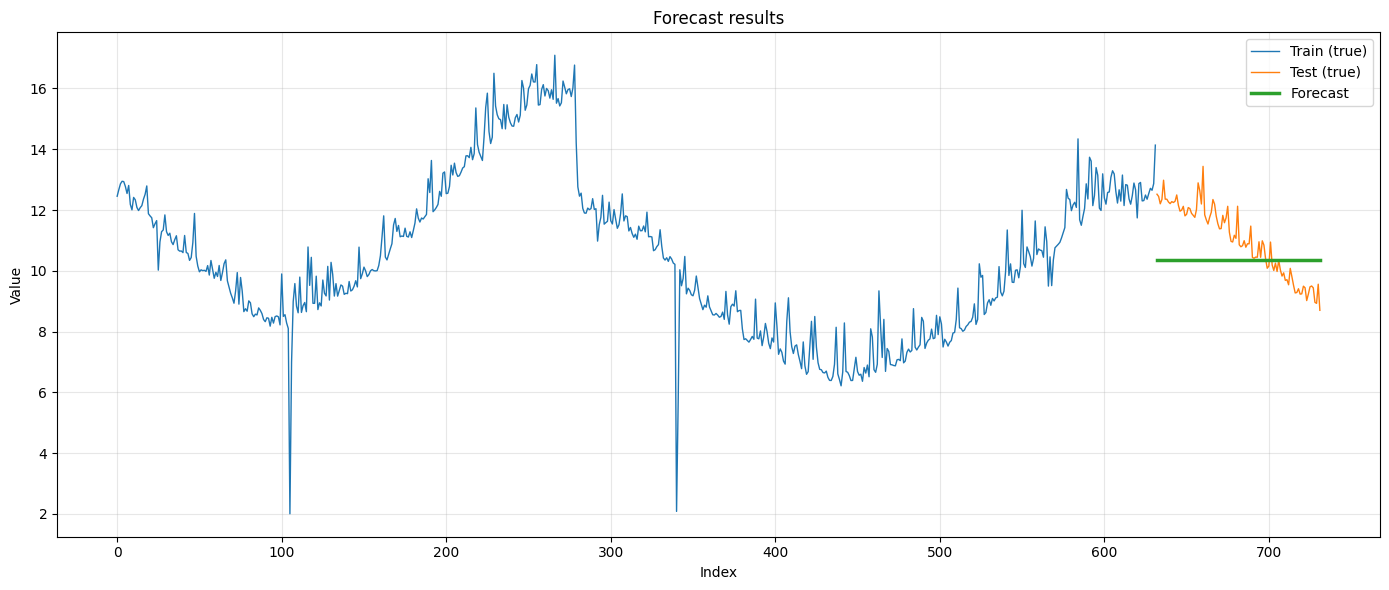

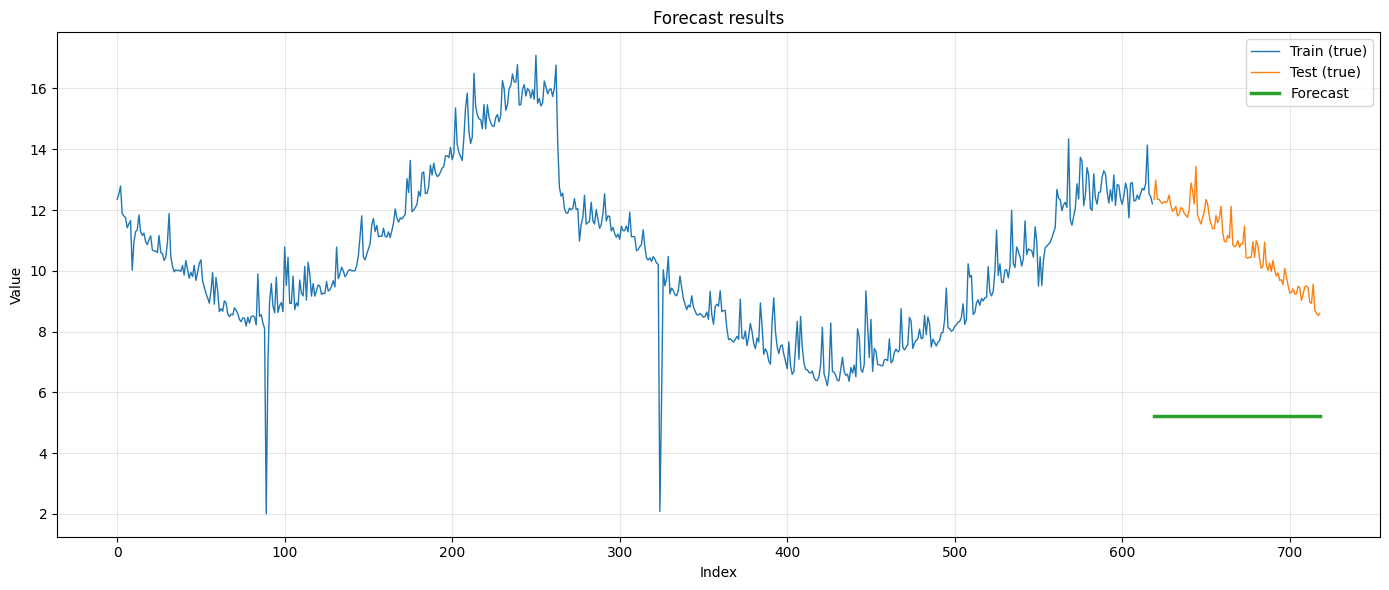

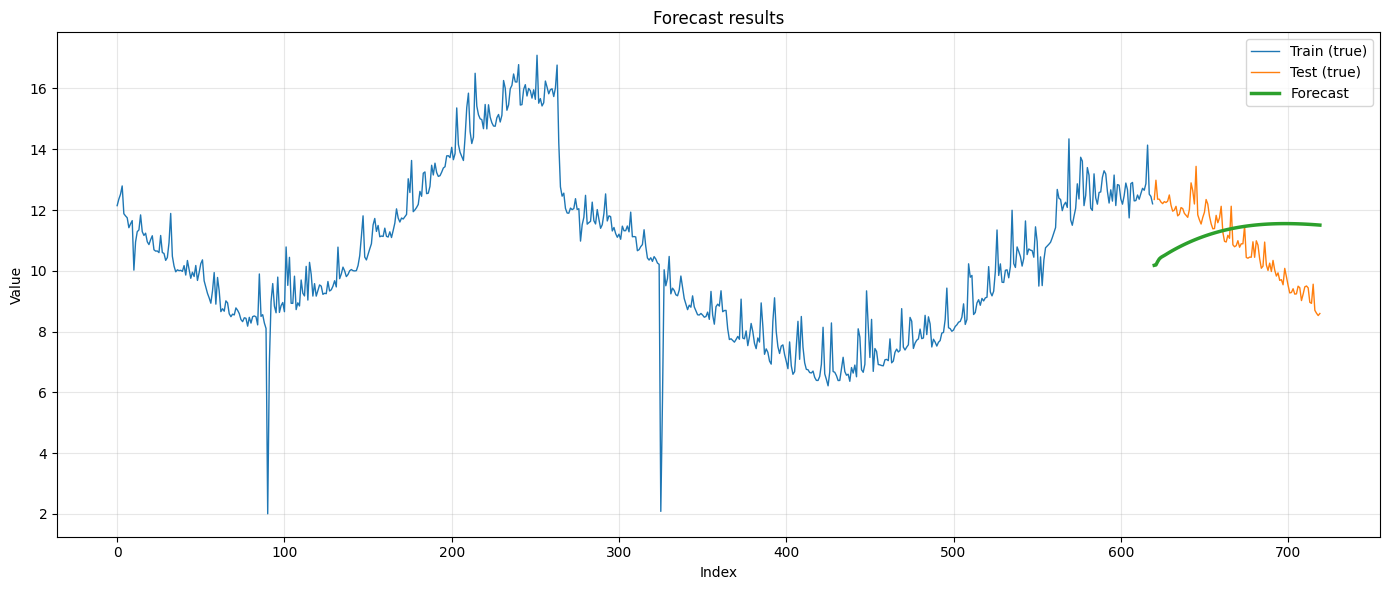

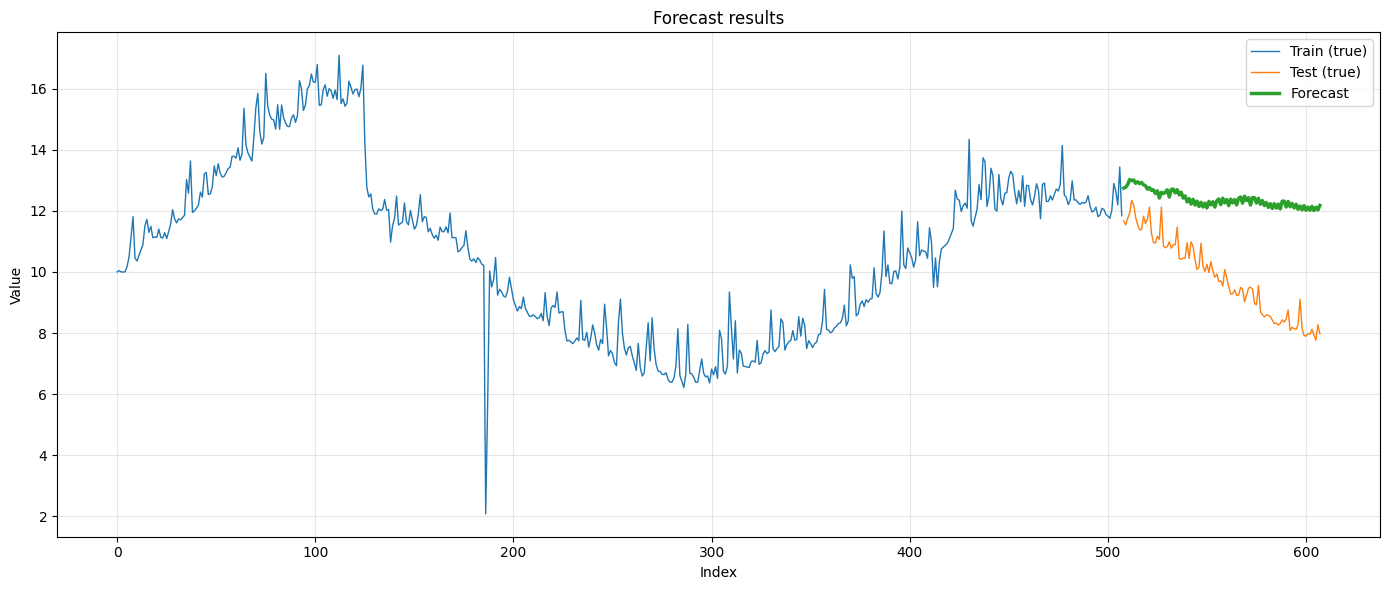

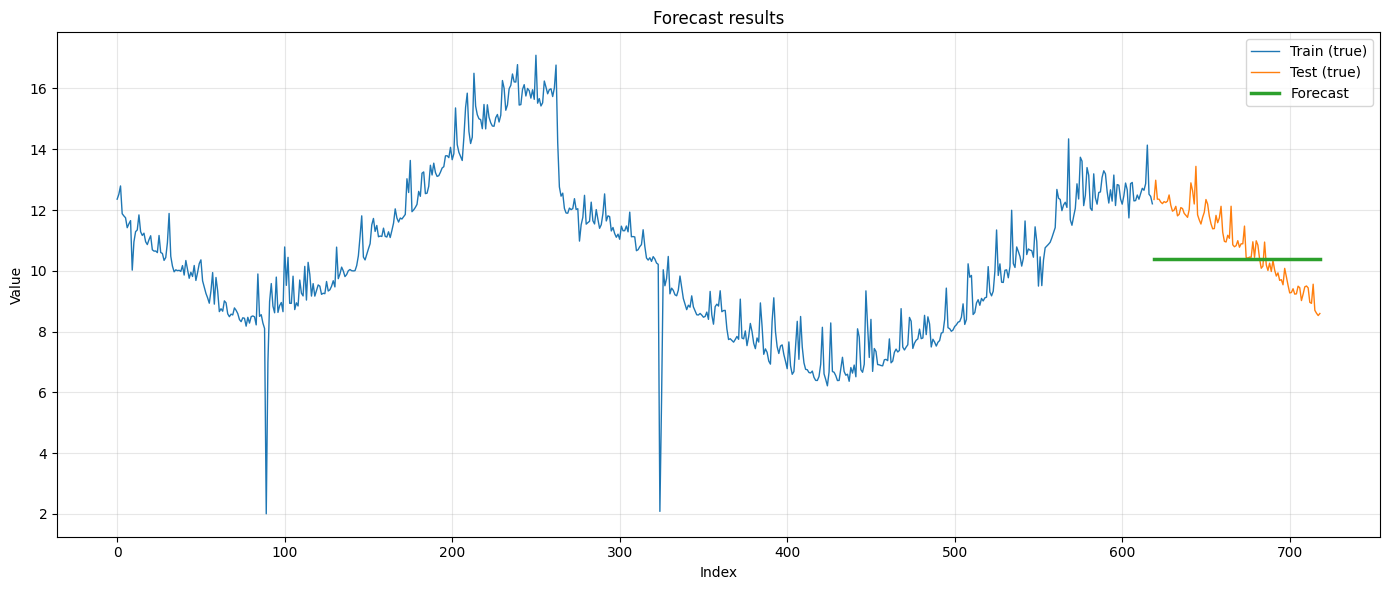

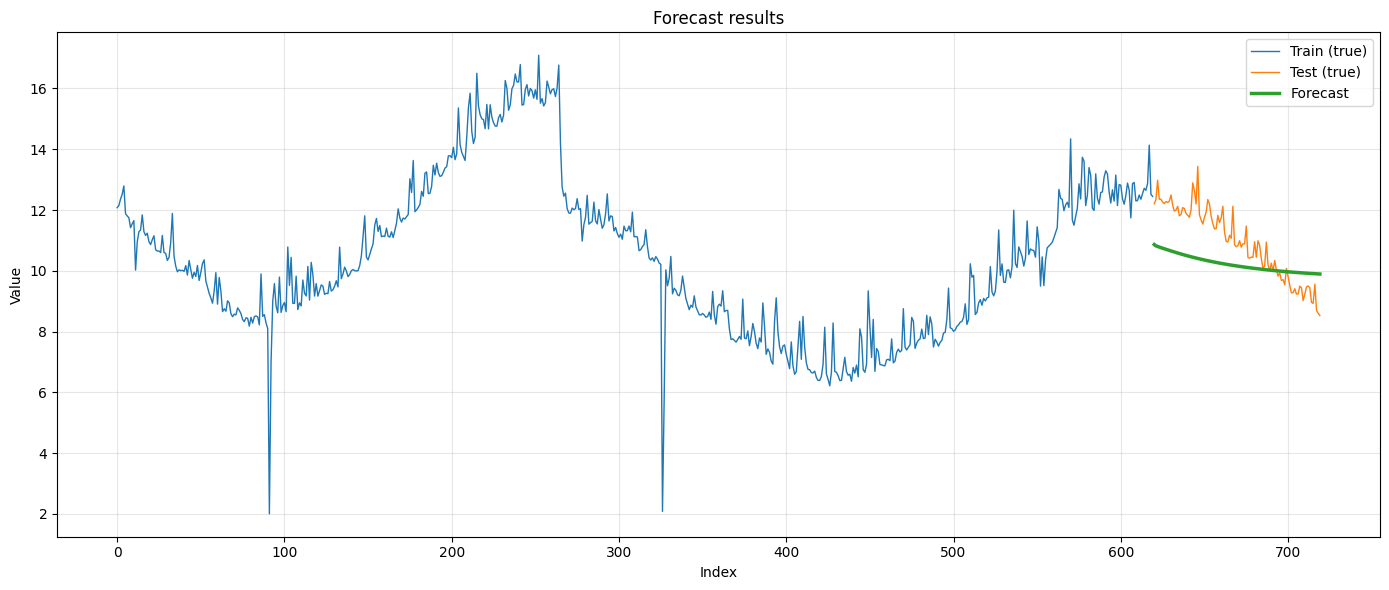

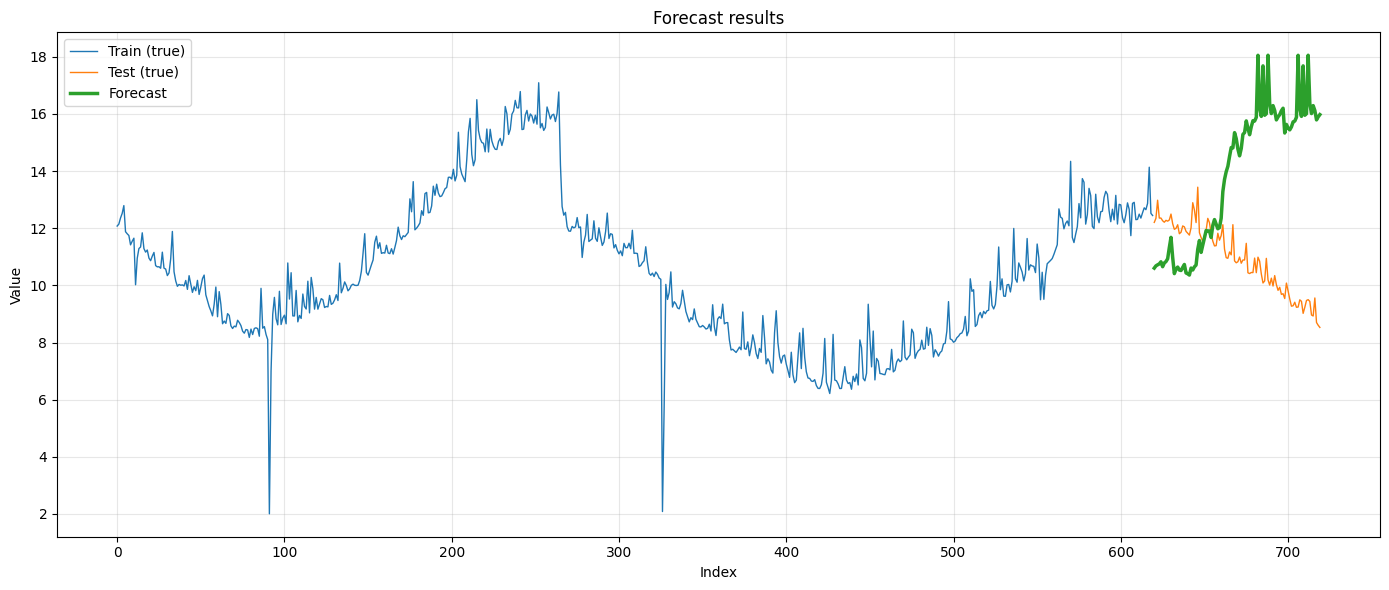

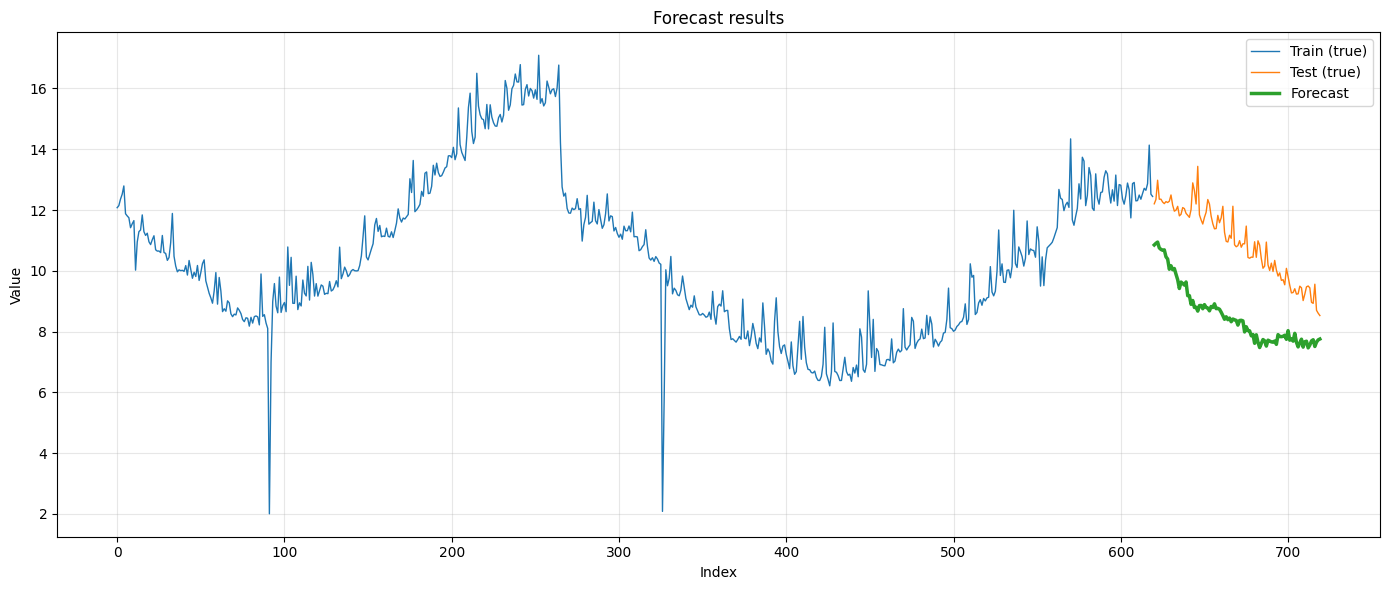

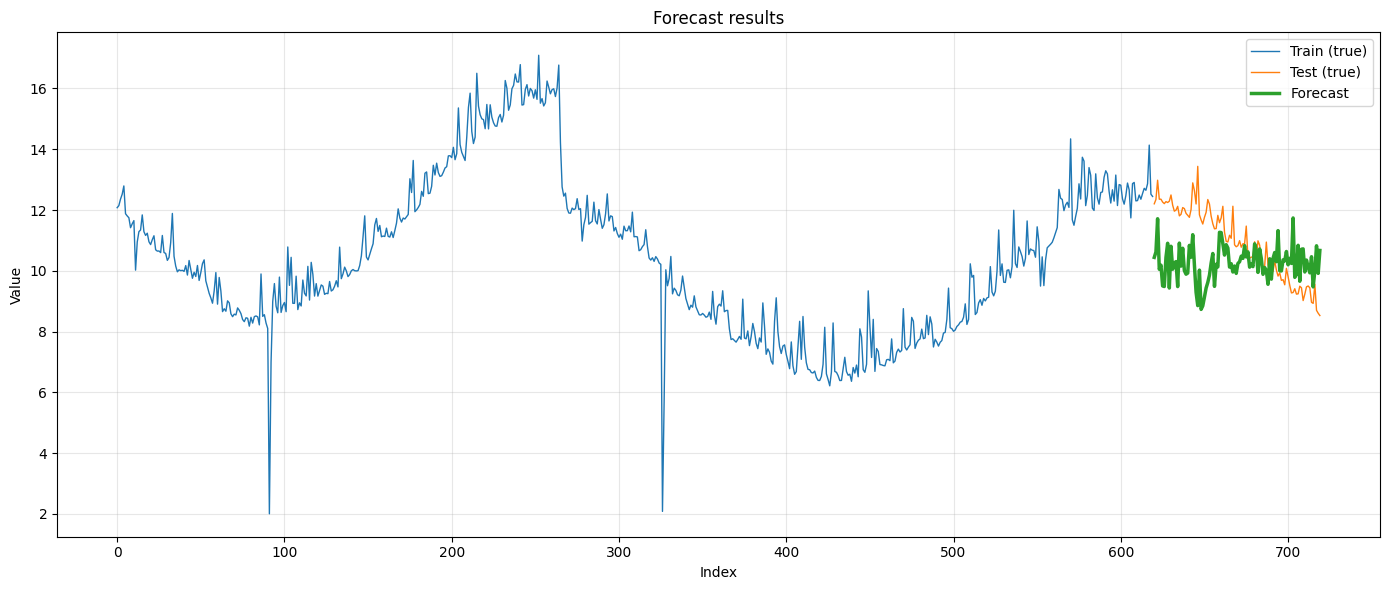

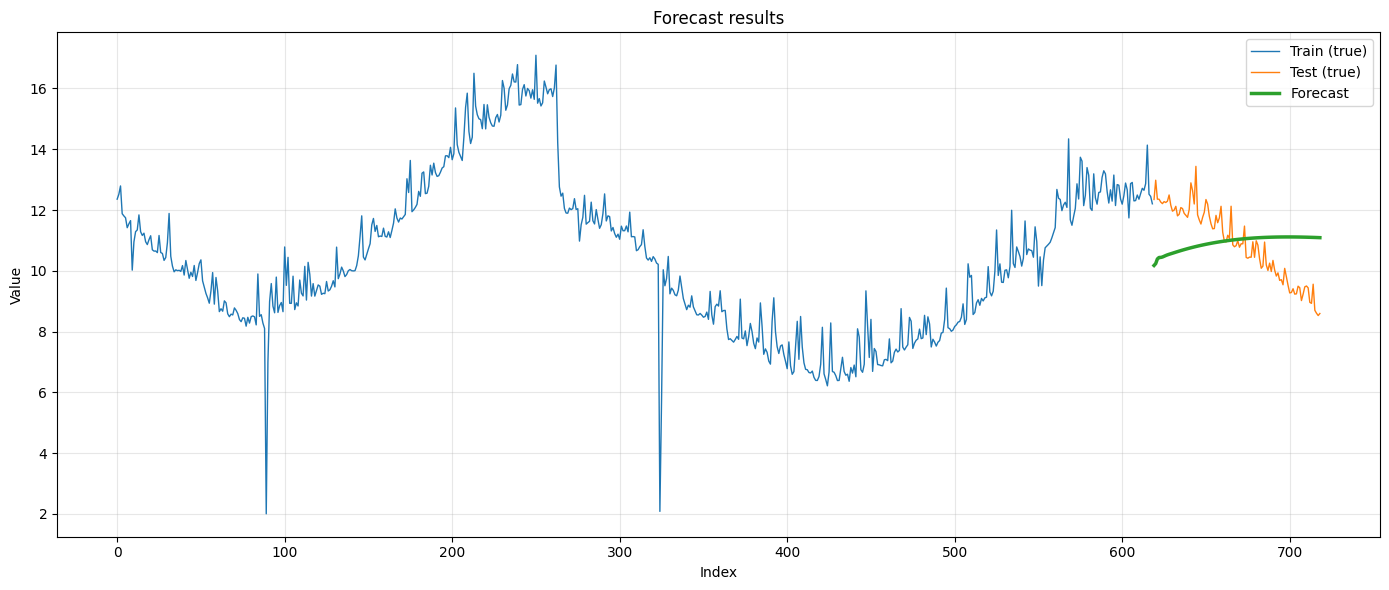

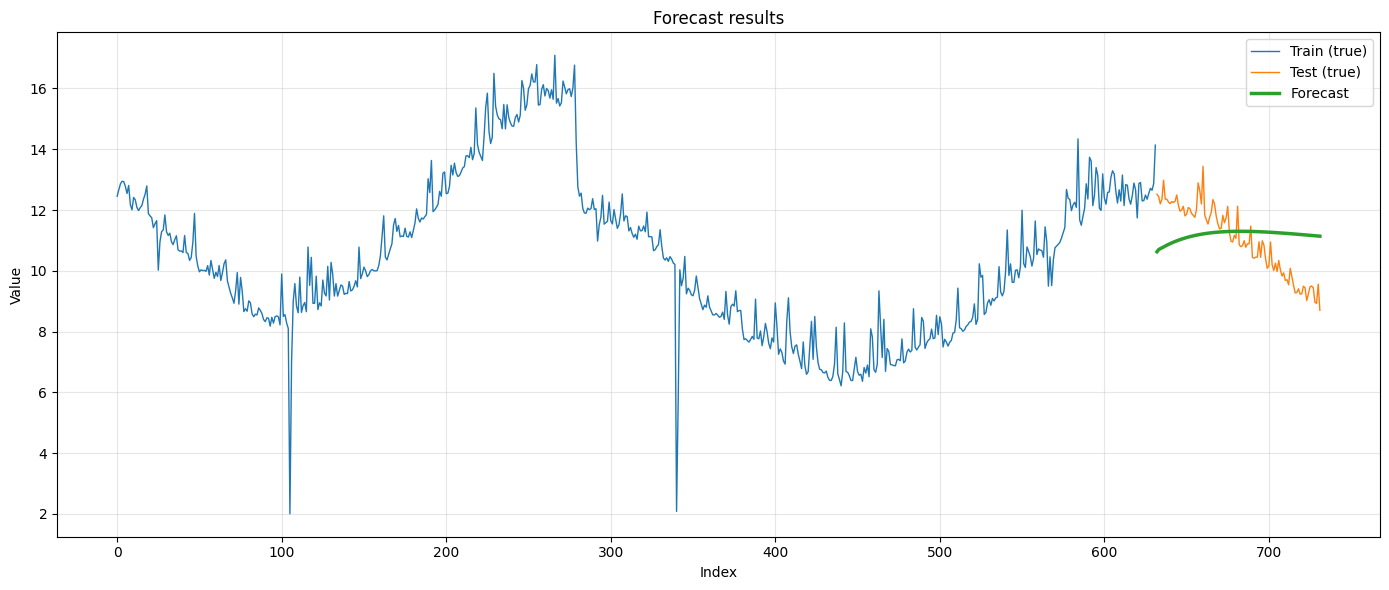

In [6]:
for trial in best["trials"]:
    X_all = trial["X_all"]
    y_pred = trial["y_pred"]
    plot_forecast_simple(X_all, y_pred)